# VIXM Predictor using an adaBoost Model

In [683]:
# Import appropriate modules

import pandas as pd
import numpy as np
from pathlib import Path
import datetime as dt
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import yfinance as yf

#from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

import hvplot
import hvplot.pandas
import matplotlib.pyplot as plt
#from sklearn.decomposition import PCA


#from imblearn.over_sampling import RandomOverSampler

# Imports from internal packages
import sys

module_path1 = str(Path("vixcoin_functions/"))
if module_path1 not in sys.path:
    sys.path.append(module_path1)
from feature_functions import (garch_fit_and_predict, 
                               correlation_filter, 
                               retrieve_yahoo_close, 
                               retrieve_yahoo_volume)


module_path2 = str(Path("vixcoin_functions/"))
if module_path2 not in sys.path:
    sys.path.append(module_path2)
from pca_and_training import (  split_training_test_data, 
                                scale, 
                                adaboost_pca, 
                                create_pca_lag, 
                                concatenate_lags, 
                                combine_train_test, 
                                concatenate_with_pca_lags, 
                                eliminate_nans_in_pca_data, 
                                random_over_sample

)

#OneHotEncoder,
#from sklearn.model_selection import train_test_split
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.models import Sequential
#import tensorflow as tf

# CONTROL PANEL

In [687]:
# Key parameters of the model

# Min return to set up a positive signal
threshold= 0.00 

# Split of data
training_period_months = 104

# Adaboost parameters
adaboost_estimators = 16 #14
max_depth=2 #2
learning_rate_adaboost = 1.4 #1.8


# Inclusion of the first 4 components lag1
#n: number of components to include
number_of_pca_lag_component_to_include = 4
num_pca_components = 40


# Definition of demo mode or development mode
demo_mode = False
parameter_tuning_mode = False
run_multiple_tuning_iterations = False

#Dates
start_date='2011-02-01'
today=datetime.today().date()
end_date=(today+DateOffset(days=-5)).date()
start_date_volatilities=(pd.to_datetime(start_date)+DateOffset(days=-364)).date()


print(f"start date: {start_date}, end date: {end_date}, start date rolling volatilities: {start_date_volatilities}")

start date: 2011-02-01, end date: 2021-11-24, start date rolling volatilities: 2010-02-02


# Generation of the Features Matrix X

### X1: close prices
#### 40 units: 
    * Close prices of international indexes of stocks and bonds, 
    * key stocks, 
    * currency exchange rates, 
    * commodities 

In [688]:
# Ticker List: VIX must be in first position

ticker_list= ["VIXM","^VIX", "spy", 
              'GBPUSD=X', 'BRLUSD=X', "DX-Y.NYB","USDJPY=X", 
              '^TNX', 'ZF=F', 'NQ=F','NKD=F',                                       
              'LQD',
              'AAPL', 'AMZN','MU','MSFT', 'BMY', 'PLD', 
              "FXI", 'FEZ', '^FTSE','^FCHI','^GSPC',
              "gld", "slv", 
              "ES=F","QM=F", "BIO=F"
             ]
    
# Some of the less familiar tickers are listed below
# CAC 40 (^FCHI)
# Yen Denominated TOPIX Futures,D (TPY=F)
# FTSE 100 (^FTSE)
# SPDR EURO STOXX 50 ETF (FEZ)
# DAX PERFORMANCE-INDEX (^GDAXI)
# S&P500 Index (^GSPC)
# HANG SENG INDEX (^HSI)
# 13 Week Treasury Bill (^IRX) --eliminate
# Nikkei/USD Futures,Dec-2021 (NKD=F)
# iShares iBoxx $ Investment Grade Corporate Bond ETF (LQD)
# Nasdaq 100 Dec 21 (NQ=F)
# NVIDIA Corporation (NVDA)
# Euro spot  'EURUSD'
# American Funds U.S. Government Securities Fund Class C (UGSCX) - 2001
# Micron Technology, Inc. (MU)
# Microsoft Corporation (MSFT)
# Bristol-Myers Squibb Company (BMY)
# FEDEX CORP (FDX)
# The Goldman Sachs Group, Inc. (GS)
# Prologis, Inc. (PLD)
# Treasury Yield 10 Years (^TNX) -- 1985
# Energy Select Sector SPDR Fund (XLE)
# Financial Select Sector SPDR Fund (XLF)
# U.S. Treasury Bond Futures,Dec- (ZB=F) - 2000
# Five-Year US Treasury Note Futu (ZF=F) - 2000
# E-Mini S&P500 (ES=F)
# E-Mini oil (QM=F)
# E-MinI Nasdaq (BIO=F)
print(f"Current number of tickers: {len(ticker_list)}")


Current number of tickers: 28


In [689]:
# X1: Upload of data using API
def retrieve_close(close_prices_dict, ticker_list):
    """
    This function retrieves close prices from Yahoo Finance
    
    Arg:
    close_prices_dict: empty dictionary to be filled with the close prices
    ticker_list: a list of tickers of the yahoo close prices to be retrieve
    
    Return:
    A dictionary with close prices
    """
    
    
    for ticker in ticker_list:
        close_price = retrieve_yahoo_close(ticker, start_date=start_date, end_date=end_date)
        close_prices_dict[ticker] = close_price
    return close_prices_dict


if demo_mode == True:
    close_prices_df_raw = pd.read_csv("demo_data/adaboost_close_prices.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
else:
    close_prices_dict = {}
    close_prices_dict = retrieve_close(close_prices_dict, ticker_list)
    close_prices_df_raw= pd.DataFrame(close_prices_dict)
    close_prices_df_raw.to_csv("demo_data/adaboost_close_prices.csv", index=True)
print("Completed retrieve of close prices")

Processing Close VIXM
Processing Close ^VIX
Processing Close spy
Processing Close GBPUSD=X
Processing Close BRLUSD=X
Processing Close DX-Y.NYB
Processing Close USDJPY=X
Processing Close ^TNX
Processing Close ZF=F
Processing Close NQ=F
Processing Close NKD=F
Processing Close LQD
Processing Close AAPL
Processing Close AMZN
Processing Close MU
Processing Close MSFT
Processing Close BMY
Processing Close PLD
Processing Close FXI
Processing Close FEZ
Processing Close ^FTSE
Processing Close ^FCHI
Processing Close ^GSPC
Processing Close gld
Processing Close slv
Processing Close ES=F
Processing Close QM=F
Processing Close BIO=F
Completed retrieve of close prices


In [690]:
#close_prices_df_raw.loc['2011-07-1':'2011-07-06']

In [691]:
# X1 Fill of missing values
close_prices_df=close_prices_df_raw.ffill(axis='rows')
close_prices_df=close_prices_df_raw.bfill(axis='rows')

# Apply correlation filter to keep just series with some minimum level of correlation of 0.2
close_prices_component_df = correlation_filter(close_prices_df, min_corr=0.05, key_column='VIXM', eliminate_first_column=False)
close_prices_component_df=close_prices_component_df.ffill(axis='rows')
close_prices_componennt_df=close_prices_component_df.bfill(axis='rows')

# First columns is not given back, so we take opportunity to rename them
X1_no_suffix=close_prices_component_df
X1=X1_no_suffix.add_suffix("_close")

# Additional time series for easy manipulation of VIXM close and returns
vixm=X1['VIXM_close']
vixm_ret=X1['VIXM_close'].pct_change()

vixm=pd.DataFrame([vixm]).T
vixm.columns=['VIXM']  # 'vixm' will represent the close and 'vixm_ret' the return

vixm_ret=pd.DataFrame([vixm_ret]).T
vixm_ret.columns=['VIXM_ret']

if demo_mode==False:
        print(X1.tail())

print("Completed inclusion of close prices")

            VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2021-11-18   30.860001   17.590000  469.730011        1.349164   
2021-11-19   30.809999   17.910000  468.890015        1.349965   
2021-11-22   31.070000   19.170000  467.570007        1.343454   
2021-11-23   30.690001   19.379999  468.190002        1.339764   
2021-11-24   30.690001   19.379999  468.190002        1.337596   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  \
Date                                                                     
2021-11-18        0.180874       95.540001      114.190002       1.589   
2021-11-19        0.179973       96.070000      114.281998       1.536   
2021-11-22        0.178202       96.500000      114.138000       1.625   
2021-11-23        0.179032       96.489998      114.790001       1.667   
2021-11-24        0.179520       96.839996      115.140999       1.645   

            ZF=F_c

In [692]:
#close_prices_df
#X1

In [693]:
# Presentation graphs of the SPY and the VIX

presentation_graph=pd.concat([X1['spy_close'], 2.5*X1['VIXM_close']],axis=1).hvplot(
        title='VIXM and S&P (Scale adjusted)',
        width=1000
)
presentation_graph


graph1=X1['spy_close'].hvplot(
                title= "SPY: iShares S&P 500 ETF Close Price",
                ylabel= 'Close Price [$]'
) 
display(graph1)

# Missing VXX. Needs to be added to tickers in order to generate this graph
#graph2=close_prices_df_raw.hvplot(
#                y=['VIXM',  "VXX"],
#                color =["blue", "black", "orange"],
#                title ='VIX Investment Vehicles: VIXM & VXX Close Prices, Time Decay Effect',
#                ylabel= 'Close Price [$]',
#               height=500
#)

#display(graph2)

#100*close_prices_df_raw[['VIXM',  "VXX", "VXZ","UVXY" ]].pct_change().describe()


# close_prices_df_raw[['VIXM',  "VXX", "VXZ", "UVXY" ]].head()

:Curve   [Date]   (spy_close)

### X2: returns

In [694]:
# Inclusion of security returns X2
# Include returns that are correlated more than 0.20 with the VIXM return

security_returns_df= close_prices_df.pct_change()
security_returns_component_df = correlation_filter(
                                        security_returns_df, 
                                        min_corr=0.05, 
                                        key_column='VIXM', 
                                        eliminate_first_column=False
)

X2_no_suffix=security_returns_component_df

X2 = X2_no_suffix.add_suffix("_returns")

print("Completed inclusion of returns")

#X2

Completed inclusion of returns


In [695]:
#security_returns_component_df.head()
#X2

### X3: volume

In [696]:
# inclusion of security volume X3
volume_list = ticker_list[0:len(ticker_list)]

def retrieve_volume(volume_dict, volume_list):
    """
    This function retrieve volume trades from a list of tickers
    
    Args:
    volume_dict: an initial dictionary to populate
    volume_list: the list of tickers for which to retrieve the volume
    
    
    Return:
    The original dictionary filled with the volume of the list of tickers
    """
    for ticker in volume_list:        
        volume = retrieve_yahoo_volume(ticker, start_date=start_date, end_date=end_date)
        volume_dict[ticker] = volume
    return volume_dict

if demo_mode == True:
    volume_df = pd.read_csv("demo_data/adaboost_volume.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
else:
    volume_dict = {}
    volume_dict = retrieve_volume(volume_dict, volume_list)
    volume_df= pd.DataFrame(volume_dict)
    volume_df.to_csv("demo_data/adaboost_volume.csv", index=True)
print("Completed retrieve of volume")

volume_df_with_vixm=pd.concat([vixm_ret, volume_df], axis=1)
#print(volume_df_with_vixm.corr())

volume_component_df = correlation_filter(volume_df_with_vixm, min_corr=0.14, key_column='VIXM_ret', eliminate_first_column=True )
X3_no_suffix=volume_component_df

X3=X3_no_suffix.add_suffix("_volume")

Processing Volume VIXM
Processing Volume ^VIX
Processing Volume spy
Processing Volume GBPUSD=X
Processing Volume BRLUSD=X
Processing Volume DX-Y.NYB
Processing Volume USDJPY=X
Processing Volume ^TNX
Processing Volume ZF=F
Processing Volume NQ=F
Processing Volume NKD=F
Processing Volume LQD
Processing Volume AAPL
Processing Volume AMZN
Processing Volume MU
Processing Volume MSFT
Processing Volume BMY
Processing Volume PLD
Processing Volume FXI
Processing Volume FEZ
Processing Volume ^FTSE
Processing Volume ^FCHI
Processing Volume ^GSPC
Processing Volume gld
Processing Volume slv
Processing Volume ES=F
Processing Volume QM=F
Processing Volume BIO=F
Completed retrieve of volume


In [697]:
#volume_component_df
#X3
#volume_df_with_vixm

### X4: GARCH Models
    * GJR-GARCH Model conditional volatility
    * Model a response to shocks
    * Allow an asymmetryc t-student distribution 

In [698]:
# Inclusion of GARCH series X4
garch_series_df=pd.DataFrame()

not_to_include=['BIO=F']


for ticker in ticker_list:
    
        if ticker in not_to_include:
            continue
    
        if demo_mode == True:
            print_series = False
        else:
            print_series = True
        garch_series_df[ticker]=garch_fit_and_predict(security_returns_df[ticker], ticker, horizon=1, p=1, q=1, o=1, print_series_name=print_series)
            
        
X4_no_suffix=garch_series_df
X4=X4_no_suffix.add_suffix("_garch")

if demo_mode == False:
    X4

print('GARCH Process fit and predictions completed')


Processing series: VIXM.....
Processing series: ^VIX.....
Processing series: spy.....
Processing series: GBPUSD=X.....
Processing series: BRLUSD=X.....
Processing series: DX-Y.NYB.....
Processing series: USDJPY=X.....
Processing series: ^TNX.....
Processing series: ZF=F.....
Processing series: NQ=F.....
Processing series: NKD=F.....
Processing series: LQD.....
Processing series: AAPL.....
Processing series: AMZN.....
Processing series: MU.....
Processing series: MSFT.....
Processing series: BMY.....
Processing series: PLD.....
Processing series: FXI.....
Processing series: FEZ.....
Processing series: ^FTSE.....
Processing series: ^FCHI.....
Processing series: ^GSPC.....
Processing series: gld.....
Processing series: slv.....
Processing series: ES=F.....
Processing series: QM=F.....
GARCH Process fit and predictions completed


In [699]:
#garch_series_df
#X4

### X5: Return squared


In [700]:
# Inclusion of return squares in X5

returns_squared_df= security_returns_df**2
returns_squared_and_vixm_ret_df=pd.concat([vixm_ret,returns_squared_df], axis=1)
returns_squared_and_vixm_ret_df
returns_squared_component_df = correlation_filter(returns_squared_and_vixm_ret_df, min_corr=0.20, key_column='VIXM', eliminate_first_column=True)

X5_no_suffix_df=returns_squared_component_df
X5=X5_no_suffix_df.add_suffix("_return_squared")

if demo_mode == False:
    X5
print("Completed inclusion of return squared")
X5.head()

Completed inclusion of return squared


,VIXM_return_squared,^VIX_return_squared,spy_return_squared,DX-Y.NYB_return_squared,^TNX_return_squared,ZF=F_return_squared,NQ=F_return_squared,NKD=F_return_squared,LQD_return_squared,AAPL_return_squared,...,BMY_return_squared,PLD_return_squared,FXI_return_squared,FEZ_return_squared,^FTSE_return_squared,^FCHI_return_squared,^GSPC_return_squared,slv_return_squared,ES=F_return_squared,BIO=F_return_squared
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-02,0.000005,0.000350,0.000004,1.363806e-06,0.000179,1.051213e-05,1.402019e-06,0.000146,0.000004,0.000004,...,1.567459e-07,6.606167e-05,0.000001,0.000029,0.000050,0.000002,0.000007,0.000042,0.000004,1.657370e-07
2011-02-03,0.000036,0.001243,0.000005,5.846745e-05,0.000222,6.032854e-06,7.433231e-07,0.000023,0.000006,0.000007,...,7.572805e-05,1.805474e-05,0.000007,0.000106,0.000008,0.000054,0.000006,0.000470,0.000006,3.481345e-05
2011-02-04,0.000152,0.002074,0.000008,1.391227e-05,0.000983,2.169959e-05,4.601826e-05,0.000153,0.000009,0.000079,...,6.152008e-05,9.133120e-08,0.000020,0.000002,0.000006,0.000007,0.000008,0.000015,0.000009,6.545052e-06
2011-02-07,0.000159,0.000483,0.000039,1.642673e-08,0.000005,7.152057e-08,1.029483e-05,0.000006,0.000001,0.000241,...,2.558484e-05,1.460397e-04,0.000087,0.000025,0.000080,0.000116,0.000039,0.000084,0.000042,1.041871e-06


In [701]:
#returns_squared_df
#X5

### X8: volatility of the SPY in several rolling windows

In [702]:
# SPY volatility on varios tracks X8

#if demo_mode == True:
#    close_price_spy_df = pd.read_csv("demo_data/adaboost_spy_data.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
    
# Retrieve yahoo close prices for spy, so to be able to calculate rolling volatilities
#else:
close_price_spy_df = retrieve_yahoo_close('spy', start_date= start_date_volatilities, end_date=end_date)  #MATCH DATE ABOVE
close_price_spy_df.to_csv("demo_data/adaboost_spy_data.csv", index=True)
    
# Calculate returns
spy_returns_df=close_price_spy_df.pct_change()

#Initialize dataframe for volatility
spy_volatility=pd.DataFrame()

# Define rolling windows to create
windows_for_lag=[10,20,30,60,90,120,180,200,260]

# Loop to create the volatilities
for window_size in windows_for_lag:
    column_name=f"{window_size}_spy_rolling_volatility"
    spy_volatility[column_name] = spy_returns_df.rolling(window=window_size).std()

# Concatenate to vix to uniform index
X8=pd.concat([vixm, spy_volatility], axis=1)

# Define min and max values for the window
X8=X8.loc[start_date:end_date,:]        
    
# Fill missing data
X8=X8.ffill()
X8=X8.iloc[:,1:]

# Setting for demo
if demo_mode == False:
    X8.shape
print("Inclusion of rolling volatilities completed")
X8.tail()

Processing Close spy
Inclusion of rolling volatilities completed


,10_spy_rolling_volatility,20_spy_rolling_volatility,30_spy_rolling_volatility,60_spy_rolling_volatility,90_spy_rolling_volatility,120_spy_rolling_volatility,180_spy_rolling_volatility,200_spy_rolling_volatility,260_spy_rolling_volatility
Date,,,,,,,,,
2021-11-18,0.004409,0.004250,0.005096,0.007025,0.006788,0.006479,0.006872,0.007338,0.007625
2021-11-19,0.004343,0.004279,0.005095,0.006978,0.006778,0.006484,0.006860,0.007337,0.007595
2021-11-22,0.004425,0.004303,0.004868,0.006914,0.006726,0.006479,0.006797,0.007329,0.007597
2021-11-23,0.004315,0.004302,0.004785,0.006897,0.006514,0.006436,0.006786,0.007328,0.007587
2021-11-24,0.004315,0.004302,0.004785,0.006897,0.006514,0.006436,0.006786,0.007328,0.007587


In [703]:
#spy_volatility
#X8

### X10: Day of the Week effect

In [704]:
# Construct dataframe with the days of the week  
#0: Monday, 6: Sunday

# Calculate list of day of week
day_of_week = close_prices_df['VIXM'].index.dayofweek

# Contruct dataframe
day_of_week_df = pd.DataFrame(day_of_week, index=close_prices_df['VIXM'].index)

#Transform columns to features columns signaling the day of the week as boolean
day_of_week_df = pd.concat([day_of_week_df,pd.get_dummies(day_of_week_df["Date"])],axis=1)

#Drop the "Date" column with the day of the week as integer and rename the columns with the day of the week
day_of_week_df.drop(columns=["Date"], inplace=True)
day_of_week_df.columns=["Mon", "Tue", "Wed","Thu","Fri"]
day_of_week_df

X10=day_of_week_df
if demo_mode == False:
    display(X10.shape)
    display(X10.value_counts())
print("Completed inclusion of day of the week effect")

(2822, 5)

Mon  Tue  Wed  Thu  Fri
0    0    1    0    0      565
     1    0    0    0      565
     0    0    0    1      564
               1    0      564
1    0    0    0    0      564
dtype: int64

Completed inclusion of day of the week effect


### X11: Month effect

In [705]:
# Construct dataframe with the month of the observation

# Calculate list of month
month=close_prices_df['VIXM'].index.month

# Contruct dataframe
month_df= pd.DataFrame(month, index=close_prices_df['VIXM'].index)

#Transform columns to features columns signaling the month as boolean
month_df=pd.concat([month_df,pd.get_dummies(month_df["Date"])],axis=1)

#Drop the "Date" column with the day of the week as integer and rename the columns with the day of the week
month_df.drop(columns=["Date"], inplace=True)
month_df.columns=["Jan", "Feb", "Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
month_df

X11=month_df
if demo_mode == False:
    display(X10.shape)
    display(X10.value_counts())
print("Completed inclusion of month effect")

(2822, 5)

Mon  Tue  Wed  Thu  Fri
0    0    1    0    0      565
     1    0    0    0      565
     0    0    0    1      564
               1    0      564
1    0    0    0    0      564
dtype: int64

Completed inclusion of month effect


# GENERATION OF THE FEATURE MATRIX **X**

In [706]:
# Concatenation of all sources of data
XY=pd.concat([X1, X2, X3, X4, X5,   X8,   X10, X11], axis=1) # X6,X7,X9 X11
if parameter_tuning_mode == True:
    print(XY.shape)
    print(XY.head())
    print(XY)

if parameter_tuning_mode == True:
    print(XY.shape)

# Interpolation is not applied to numerical variables. We are just going to drop those.
print(f"XY.shape:  {XY.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X1.shape:  {X1.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X2.shape:  {X2.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X3.shape:  {X3.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X4.shape:  {X4.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X5.shape:  {X5.shape}, {XY.index.min()}, {XY.index.max()} ")

print(f"X8.shape:  {X8.shape}, {XY.index.min()}, {XY.index.max()} ")

print(f"X10.shape: {X10.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X11.shape: {X11.shape}, {XY.index.min()}, {XY.index.max()} ")

#display(XY.isna().head(40))
#display(XY.isna().sum().tail(40))
#XY=XY.dropna()
if parameter_tuning_mode == True:
    XY.shape
    XY.head()
print(XY.columns)

XY.shape:  (2822, 133), 2011-02-01 00:00:00, 2021-11-24 00:00:00 
X1.shape:  (2822, 28), 2011-02-01 00:00:00, 2021-11-24 00:00:00 
X2.shape:  (2822, 24), 2011-02-01 00:00:00, 2021-11-24 00:00:00 
X3.shape:  (2822, 6), 2011-02-01 00:00:00, 2021-11-24 00:00:00 
X4.shape:  (2821, 27), 2011-02-01 00:00:00, 2021-11-24 00:00:00 
X5.shape:  (2822, 22), 2011-02-01 00:00:00, 2021-11-24 00:00:00 
X8.shape:  (2822, 9), 2011-02-01 00:00:00, 2021-11-24 00:00:00 
X10.shape: (2822, 5), 2011-02-01 00:00:00, 2021-11-24 00:00:00 
X11.shape: (2822, 12), 2011-02-01 00:00:00, 2021-11-24 00:00:00 
Index(['VIXM_close', '^VIX_close', 'spy_close', 'GBPUSD=X_close',
       'BRLUSD=X_close', 'DX-Y.NYB_close', 'USDJPY=X_close', '^TNX_close',
       'ZF=F_close', 'NQ=F_close',
       ...
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
      dtype='object', length=133)


# y:  Set the Signal

In [707]:
# Set the Signal column
XY["Signal"] = 0.0

XY.loc[(XY['VIXM_returns'] >= threshold), 'Signal'] = 1

# # Generate the trading signals 1 (entry for one day) or 0 (do not enter)

# Review the DataFrame
if parameter_tuning_mode == True:
    print(XY["Signal"].head())
    print(XY["Signal"].value_counts())
XY.loc[XY["Signal"]==1, 'VIXM_returns']
XY.shape  ## 2919
#XY.loc['2011-07-13':,'VIXM_returns']

(2822, 134)

In [708]:
# Define the target set y using the Signal column
y = XY["Signal"]

# Display a sample of y
if parameter_tuning_mode == True:
    display(y)

# Review of the signal
pd.concat([vixm_ret,y], axis=1).head(20)


,VIXM_ret,Signal
Date,,
2011-02-01,NaN,0.0
2011-02-02,-0.002183,0.0
2011-02-03,-0.005980,0.0
2011-02-04,-0.012326,0.0
2011-02-07,-0.012628,0.0
2011-02-08,-0.013542,0.0
2011-02-09,-0.005491,0.0
2011-02-10,-0.006442,0.0
2011-02-11,-0.012967,0.0


In [709]:
# Outputs for the model tuning

if parameter_tuning_mode == True:
    print(f"Number of NaN in signal y: {y.isna().sum()}" )
    if y.isna().sum()>=1:
        print(y[y.isna()])
    print(f"y shape:  {y.shape}")
    print(f"XY shape: {XY.shape}")
    x_nan=XY.drop(columns=["Signal"]).isna().sum()
    print(f"Number of NaN in X: {x_nan}")
    display(XY.drop(columns=['Signal']).shift().isna().sum())
    display(XY.drop(columns=['Signal']).shift().dropna().shape)

In [710]:
# Set up of X, y and outputs for the model tuning
#print(f"Original XY:{XY}")
#print(XY.isna().sum)

# X should move one step to the future. Data from yesterday should predict movements of today.
XY_modified = XY.shift().dropna()
if parameter_tuning_mode == True:
    print(f"Modified XY and shape:{XY_modified.head()}, {XY_modified.shape}" )

# Since we move XY to the future, we move back y to the past in one day, so X from yesterday will predict y today
print(f"Original y: {y.head()} ")
y = XY_modified["Signal"].shift(-1)
print(f"new y: {y.head()}")

print(f"X: {XY.head()}")
X = XY_modified

if parameter_tuning_mode == True:
    display(y.shape)
    display(X.shape)
    display(y.isna().sum())
    display(X.isna().sum())


Original y: Date
2011-02-01    0.0
2011-02-02    0.0
2011-02-03    0.0
2011-02-04    0.0
2011-02-07    0.0
Freq: B, Name: Signal, dtype: float64 
new y: Date
2011-02-14    0.0
2011-02-15    1.0
2011-02-16    0.0
2011-02-17    1.0
2011-02-18    1.0
Name: Signal, dtype: float64
X:             VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2011-02-01  274.839996   17.629999  106.105324        1.603001   
2011-02-02  274.239990   17.299999  105.902466        1.613606   
2011-02-03  272.600006   16.690001  106.137779        1.620483   
2011-02-04  269.239990   15.930000  106.438057        1.613450   
2011-02-07  265.839996   16.280001  107.103561        1.609969   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ^TNX_close  \
Date                                                                     
2011-02-01        0.599880       77.070000       82.070000       3.443   
2011-02-02        0.600528       77

In [711]:
# Review the features DataFrame
if parameter_tuning_mode == True:
    print(X.head())

In [712]:
# Review of correlations
if parameter_tuning_mode == True:
    print(X.corr())

# Split of data in Train and Test (I) and Scaling

In [713]:
# Split data into training and testing subsets

X_train, y_train, X_test, y_test = split_training_test_data(X, y, training_period_months= training_period_months, tuning_mode = parameter_tuning_mode)
print("Split of data completed")


Split of data completed


In [714]:
# Scaling of the data

# def scale(X_train, X_test, type=MinMaxScaler, tuning_mode= True): # COPIED DELETE
#     """
#     This function apply standard scaling to a divided set of features divided as train and test data
    
#     Args:
#     The two dataframes:
#     X_train: a pandas dataframe with features of the training window
#     X_test:  a pandas dataframe with features of the test window
    
#     Return:
#     Two arrays coming from the original dataframes after applying StandardScaler() or MinMaxScaler(), where the standarization is made using the X_train features
#     """
#     # Create an Scaler instance
#     scaler =  MinMaxScaler() 
    
#     if type=='StandardScaler':
#         scaler =  StandardScaler()  
 
#     # Apply the scaler model to fit the X_train data
#     X_scaler = scaler.fit(X_train)

#     # Transform the X_train and X_test DataFrames using the X_scaler
#     X_train_scaled = X_scaler.transform(X_train)
#     X_test_scaled = X_scaler.transform(X_test)

#     if tuning_mode == True:
#         display(X_train_scaled.shape)
#         display(X_test_scaled.shape)
#     return X_train_scaled, X_test_scaled
    
X_train_scaled, X_test_scaled = scale(X_train, X_test, type='MinMaxScaler', tuning_mode= parameter_tuning_mode)
print(X.shape)

(2693, 134)


### X lags: calculate principal components of Train data, and lagged them 
number of components tuned to 4, and considered lags: t=5 days

In [715]:
# Calculation of Principal Components

# def adaboost_pca(X_train, X_test, tuning_mode= True): # COPIED. DELETE.
    
#     """
#     This function calculates the principal components of an X features matrix, already divided in a train and a test set.
    
#     Args:
#     X_train: a pandas dataframe with the training set of features
#     X_test: a pandas dataframe with the test set of features
    
    
#     Returns:
#     An X pandas dataframe of features, with the train and test samples concatenated, which correspond
#     to the principal components of the original data, calculated using the transformation calculated from the train set of data.
#     """
    
#     # Initiate and calculate principal components transformation based on the train data
#     pca = PCA(n_components = num_pca_components)
#     pca.fit(X_train)
    
#     # Calculate train and test principal components using the trained model
#     principal_components_train = pca.transform(X_train)
#     principal_components_test  = pca.transform(X_test)
    
#     # Name principal components columns properly
#     pca_column_list = []
#     for i in range(1, num_pca_components+1):
#         pca_column_list.append(f"pca{i}")

#     #Concatenate train and test principal components in one dataframe called principal_components_train_test_df
#     principal_components_train_test = np.concatenate((principal_components_train, principal_components_test), axis = 0)
#     principal_components_train_test_df = pd.DataFrame(data = principal_components_train_test, columns = pca_column_list, index = X.index)
#     if tuning_mode == True:
#         explained_variance=sum(pca.explained_variance_ratio_)
#         print(f"Principal Components explained variance: {explained_variance*100:.2f}%")
#         print(f"Principal Components Shape:              {principal_components_train_test_df.shape}")
#         display(principal_components_train_test_df.head(5))
#     return principal_components_train_test_df


principal_components_train_test_df = adaboost_pca(
                                                    X_train_scaled, 
                                                    X_test_scaled, 
                                                    index=X.index, 
                                                    num_pca_components=num_pca_components, 
                                                    tuning_mode = parameter_tuning_mode
)

In [716]:
# Generation of lag principal components to include historical movements of the data in the model. We call this set LAG.

# def create_pca_lag(principal_components_train_test_df, shift_amount, tuning_mode=True ): #COPIED. DELETE.
#     """
#     This function creates a new dataframe by taking the first 3 first principal components (in the first three columns) and shifting them in a desire number
    
#     Args:
#     principal_components_train_test_df: a pandas dataframe 
#     shift_amount: the number of positions to shift the first three columnms
    
#     Return:
#     A pandas dataframe containing the shifted 3 first columns of the dataframe,
#     with column names 'pca1_lag1','pca2_lag1','pca3_lag1'
#     """
#     X_pc_lag = principal_components_train_test_df.iloc[:,0:(number_of_pca_lag_component_to_include-1)]
#     if parameter_tuning_mode == True:
#         display(X_pc_lag.shape)

#     X_pc_lag.columns = ['pca1_lag1','pca2_lag1','pca3_lag1']
#     X_pc_lag = X_pc_lag.shift(shift_amount)

#     if tuning_mode == True:
#         print(X_pc_lag)
#         X_pc_lag.shape
#     return X_pc_lag

# Shift the LAG components by 1
X_pca_lag1 = create_pca_lag(principal_components_train_test_df, shift_amount=1, number_of_pca_lag_component_to_include=number_of_pca_lag_component_to_include,  tuning_mode= parameter_tuning_mode)

In [717]:
# Shift the LAG components by 2    
X_pca_lag2 = create_pca_lag(
    principal_components_train_test_df, 
    shift_amount=2, 
    number_of_pca_lag_component_to_include=number_of_pca_lag_component_to_include, 
    tuning_mode= parameter_tuning_mode)

In [718]:
# Shift the LAG components by 3
X_pca_lag3 = create_pca_lag(principal_components_train_test_df, shift_amount=3, 
                            number_of_pca_lag_component_to_include=number_of_pca_lag_component_to_include,  tuning_mode= parameter_tuning_mode)

In [719]:
# Shift the LAG Components by 4
X_pca_lag4 = create_pca_lag(principal_components_train_test_df, shift_amount=4, 
                            number_of_pca_lag_component_to_include=number_of_pca_lag_component_to_include, tuning_mode= parameter_tuning_mode)

In [720]:
# Shift the LAG Components by 5
X_pca_lag5 = create_pca_lag(principal_components_train_test_df, shift_amount=5, 
                            number_of_pca_lag_component_to_include=number_of_pca_lag_component_to_include, tuning_mode= parameter_tuning_mode);

In [721]:
# def concatenate_lags(X_pc_lag1, X_pc_lag2, X_pc_lag3, X_pc_lag4, X_pc_lag5, tuning_mode = True): #COPIED. DELETE.
#     X_pc_lags=pd.concat([X_pc_lag1, 
#                          X_pc_lag2, 
#                          X_pc_lag3, 
#                          X_pc_lag4, 
#                          X_pc_lag5], 
#                          axis=1
#     )
    
#     if tuning_mode == True:
#         X_pc_lags.shape
#     return X_pc_lags

X_pc_lags = concatenate_lags(X_pca_lag1, X_pca_lag2, X_pca_lag3, X_pca_lag4, X_pca_lag5, tuning_mode= parameter_tuning_mode)

In [722]:
# Concatenation of all variables in X_pc, storing current variables plus lagged principal components

# def combine_train_test(X_train, X_test):  #Copied. DELETE
#     """
#     This function concantenate the train and test arrays, and apply the proper index, to get back to an X dataframe
    
#     Args:
#     X_train, X_test: arrays to concatenate, wich should have the same number of columns
    
#     Return:
#     The X dataframe as a pandas dataframe, and the index as the last X dataframe of features
#     """
    
#     X_combined = np.concatenate([X_train, X_test], axis = 0)
#     X_combined = pd.DataFrame(data = X_combined, index=X.index)
#     return X_combined

# def concatenate_with_pca_lags(X_raw, X_pc_lags, tuning_mode = True):
#     """
#     This function concatenates all the sources of data: features and lags principal compoents.
#     It also eliminates NaNs due to lag
    
#     Args:
#     X_raw: the combination of X_train and X_test features, excluding principal compoentns
#     X_pc_lags: the 3 main principal components of the set of features, lagged in 1, 2, 3, 4 and 5 days
    
#     Returns:
#     A dataframe containing the concatenation of all features and principal components without missing values, with the proper datetime index
#     """
    
#     X_pc = pd.concat([X_raw, X_pc_lags], axis=1)

#     if tuning_mode == True:
#         print(X_pc.shape)
#     return X_pc

X_scaled_df = combine_train_test(X_train_scaled, 
                                 X_test_scaled,
                                 index=X.index
)

X_pc = concatenate_with_pca_lags( X_scaled_df, X_pc_lags,  
                                 tuning_mode= parameter_tuning_mode
)

In [723]:
# Displaying outputs for tuning
if parameter_tuning_mode == True:
    print(f"principal_components_train_test_df.shape: {principal_components_train_test_df.shape}, {principal_components_train_test_df.index.min()}, {principal_components_train_test_df.index.max()} ")
    print(f"X_pc_lags.shape: {X_pc_lags.shape}, {X_pc_lags.index.min()}, {X_pc_lags.index.max()} ")
    print(f"X_pc.shape: {X_pc.shape}, {X_pc.index.min()}, {X_pc.index.max()} ")
    print(f"y.shape: {y.shape}, {y.index.min()}, {y.index.max()}")

In [724]:
# Elimination of missing data in principal components

# def eliminate_nans_in_pca_data(X_pc, y,  tuning_mode = True): #COPIED. DELETE.
#     X_pc = X_pc[5:-1]
#     y = y[5:-1]

#     if tuning_mode == True:
#         display(X_pc.shape)
#         display(y.shape)
#     return X_pc, y

X_pc, y = eliminate_nans_in_pca_data(X_pc, y, tuning_mode= parameter_tuning_mode)

In [725]:
# Redefinition of X and y with extended X, to apply convention to feature data with proper column names
X = X_pc

if parameter_tuning_mode == True:
    print(X.shape)
    y.shape

# Apply column names unpacking original X_train and X_pc_lags parameters
column_names = [*X_train.columns, *X_pc_lags.columns]
X.columns = column_names 


# Split the data in train and test

In [726]:
# Split of data in train and test, applying temporal window function that respect time series order, which is defined above in cell 177

X_train, y_train, X_test, y_test = split_training_test_data(X, y, training_period_months=training_period_months)
X_train_scaled, X_test_scaled = scale(X_train, X_test,type='MinMaxScaler', tuning_mode = parameter_tuning_mode)

Training dates: 2011-02-21 00:00:00 to 2019-10-21 00:00:00
y_train value_counts:


0.0    1154
1.0    1009
Name: Signal, dtype: int64

y_test shape: (524,)
X_test shape: (524, 149)
X_train shape: (2163, 149)
y_train shape: (2163,)
X_train tail(1):


,VIXM_close,^VIX_close,spy_close,GBPUSD=X_close,BRLUSD=X_close,DX-Y.NYB_close,USDJPY=X_close,^TNX_close,ZF=F_close,NQ=F_close,...,pca3_lag1,pca1_lag1,pca2_lag1,pca3_lag1,pca1_lag1,pca2_lag1,pca3_lag1,pca1_lag1,pca2_lag1,pca3_lag1
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-21,0.009585,0.131498,0.987193,0.164824,0.006057,0.802042,0.658281,0.167105,0.548503,0.973792,...,-0.227852,-1.724468,0.540552,0.616497,-1.660989,0.538616,0.696161,-1.655363,0.634547,0.847673


X_train head(1): 


,VIXM_close,^VIX_close,spy_close,GBPUSD=X_close,BRLUSD=X_close,DX-Y.NYB_close,USDJPY=X_close,^TNX_close,ZF=F_close,NQ=F_close,...,pca3_lag1,pca1_lag1,pca2_lag1,pca3_lag1,pca1_lag1,pca2_lag1,pca3_lag1,pca1_lag1,pca2_lag1,pca3_lag1
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-22,0.008481,0.125064,0.996949,0.17098,0.013114,0.803689,0.654814,0.186842,0.532335,0.985042,...,0.676819,-1.71313,0.693237,-0.227852,-1.724468,0.540552,0.616497,-1.660989,0.538616,0.696161


In [727]:
# Setting unique columns names to be able to apply random over sample model
column_name_list = []
for i in range(0, len(X.columns)):
    column_name_list.append(f"f_{i}")
X_train_unique_columns = X_train.copy()
X_train_unique_columns.columns = column_name_list


In [728]:
# Random oversample was applied since depending on the Threshold (above which return we are predicting), the sample can get highly unbalanced
# For the case of threshold = 0

# def random_over_sample(X_train, y_train, tuning_mode=True): #COPIED. DELETE FUNCTION
#     # Use RandomOverSampler to resample the dataset using random_state=1
#     ros = RandomOverSampler(random_state = 1)
#     X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

#     if parameter_tuning_mode == True:
#         display(y_train_resampled.value_counts())
#     return X_train_resampled, y_train_resampled

X_train_resampled, y_train_resampled = random_over_sample(X_train_scaled, y_train, tuning_mode = parameter_tuning_mode)
#X_train_resampled, y_train_resampled = X_train_scaled, y_train

# Adaboost Model Estimation

In [729]:
# Instance AdaBoost
# Initiate the model instance
base = DecisionTreeClassifier(max_depth=max_depth)
adaboost_model=AdaBoostClassifier(  base_estimator=base
                                  , n_estimators=adaboost_estimators
                                  , learning_rate= learning_rate_adaboost
                                  , random_state=1
)
adaboost_model

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=1.4, n_estimators=16, random_state=1)

In [730]:
# Tunning for the model
if parameter_tuning_mode == True:
    display(X_train_resampled.shape)
    display(y_train_resampled.shape)
    display(X_test_scaled.shape)
    display(y_test.shape)

In [731]:
# Fit the model 
adaboost_model = adaboost_model.fit(X_train_resampled, y_train_resampled)

pred_adaboost=adaboost_model.predict(X_test_scaled)

In [732]:
if demo_mode == False and parameter_tuning_mode == True:
    display(np.any(np.isnan(y_test)))
    display(np.all(np.isfinite(y_test)))
    display(np.any(np.isnan(pred_adaboost)))
    display(np.all(np.isfinite(pred_adaboost)))
    display(y_test.shape)
    display(pred_adaboost.shape)

In [733]:
# Use a classification report to evaluate the model using the predictions and testing data
adaboost_report=classification_report(y_test, pred_adaboost)

# Print the classification report
print("         AdaBoost Classification Report")
print(adaboost_report)


         AdaBoost Classification Report
              precision    recall  f1-score   support

         0.0       0.57      0.34      0.43       273
         1.0       0.50      0.72      0.59       251

    accuracy                           0.52       524
   macro avg       0.53      0.53      0.51       524
weighted avg       0.53      0.52      0.50       524



# Analysis of feature importance in the AdaBoost model

In [734]:
# Analysis of importance of the difference variables
# get importance
adaboost_importance_coeficients=adaboost_model.feature_importances_

feature_importance_df=pd.Series(
                                adaboost_importance_coeficients, 
                                index=X.columns)

# Output of all levels
for i,v in enumerate(adaboost_importance_coeficients):
    if v !=0:
        print(f"Feature: {i}, {X.columns[i]}, Score: {v}" )
        

# Display of only features that impacted the model
n_important_features=feature_importance_df.loc[feature_importance_df>0].shape[0]
feature_importance_df.loc[feature_importance_df>0].hvplot(
                                            kind='barh', 
                                            height=500,
                                            title= f"{n_important_features} Features relevant for the VIXM Prediction Model")

Feature: 8, ZF=F_close, Score: 0.022953540825587652
Feature: 11, LQD_close, Score: 0.022061960522530715
Feature: 28, VIXM_returns, Score: 0.027657727203993423
Feature: 29, ^VIX_returns, Score: 0.023312140982459203
Feature: 33, ZF=F_returns, Score: 0.019970925624558877
Feature: 35, NKD=F_returns, Score: 0.04582227755076749
Feature: 36, LQD_returns, Score: 0.017966631655136338
Feature: 38, AMZN_returns, Score: 0.044117391411410745
Feature: 44, FEZ_returns, Score: 0.028887749466702924
Feature: 45, ^FTSE_returns, Score: 0.023371009025901522
Feature: 49, ES=F_returns, Score: 0.017525326684432675
Feature: 52, VIXM_volume, Score: 0.009848748176832657
Feature: 56, ^GSPC_volume, Score: 0.021148950920524677
Feature: 59, ^VIX_garch, Score: 0.022513682787362977
Feature: 60, spy_garch, Score: 0.021938074559108154
Feature: 62, BRLUSD=X_garch, Score: 0.020137957630933002
Feature: 64, USDJPY=X_garch, Score: 0.02042285970902419
Feature: 67, NQ=F_garch, Score: 0.020218609746608943
Feature: 69, LQD_garch

:Bars   [index]   (0)

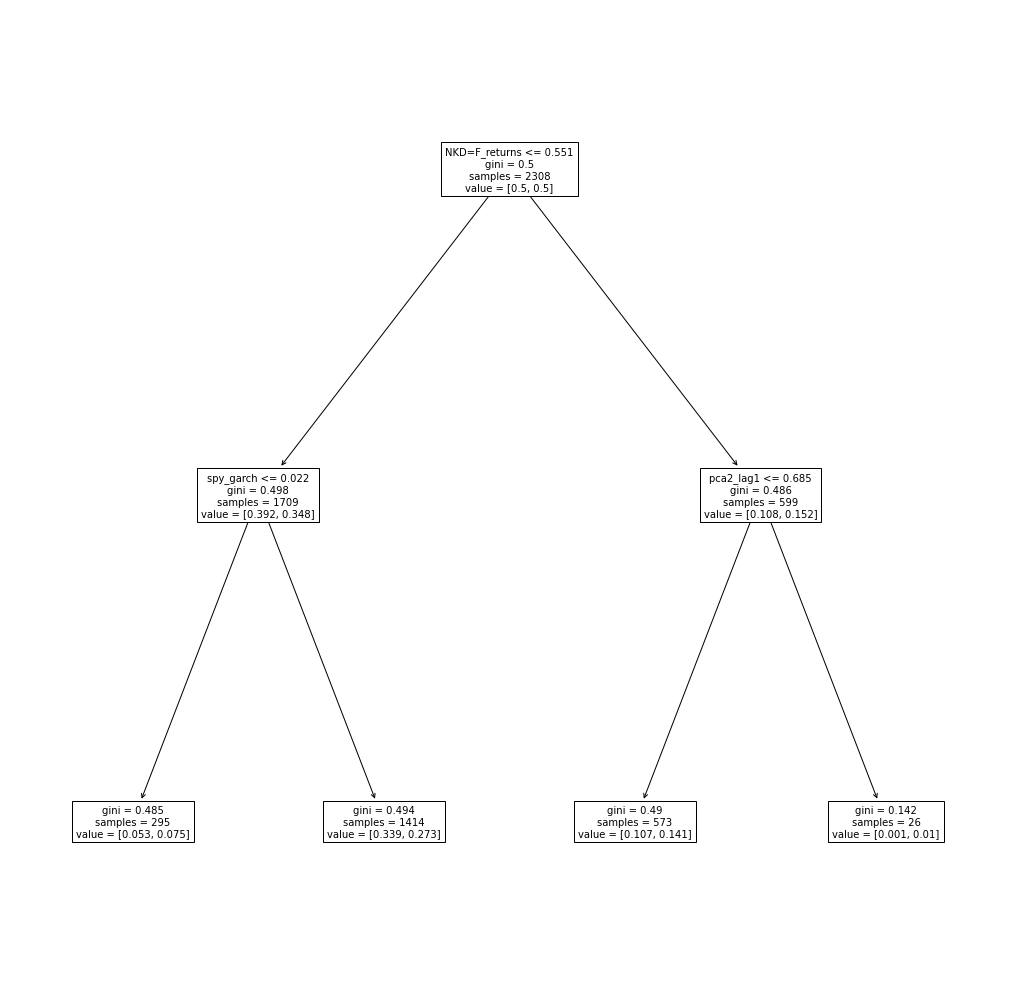

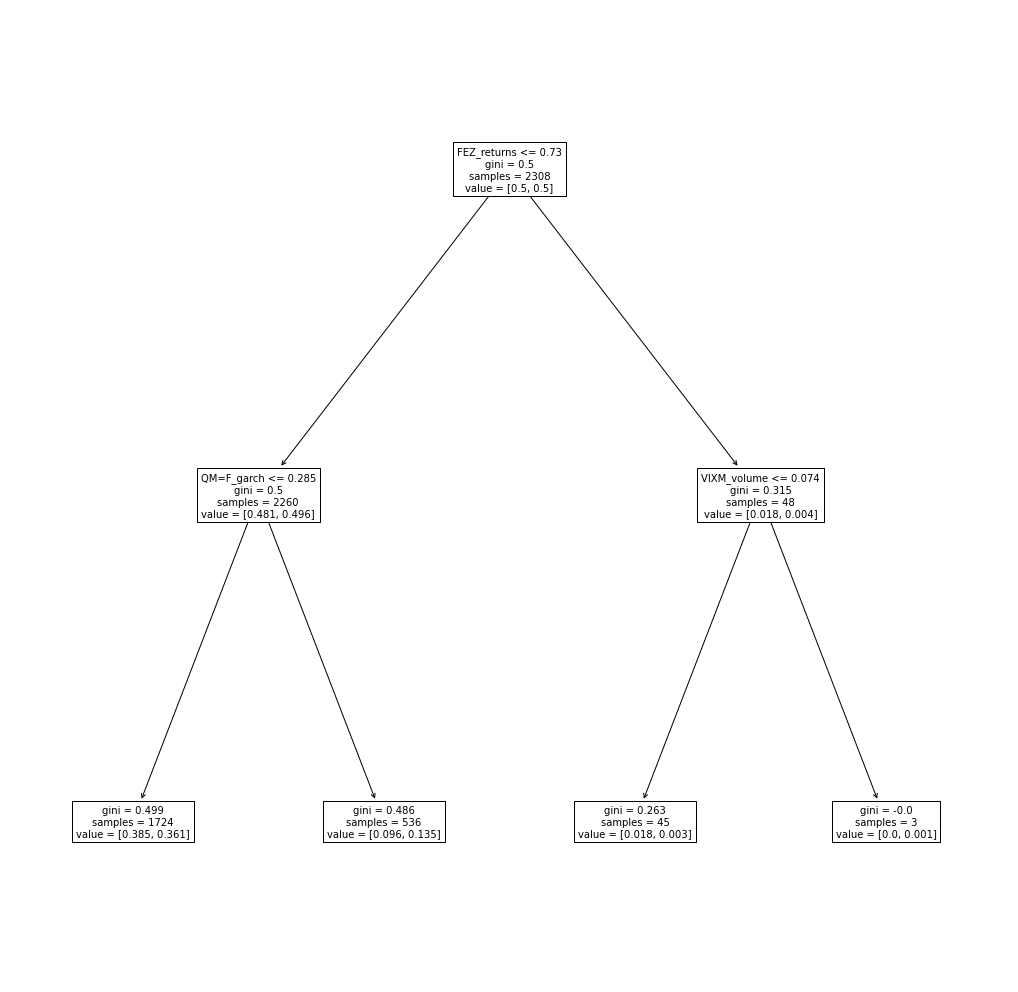

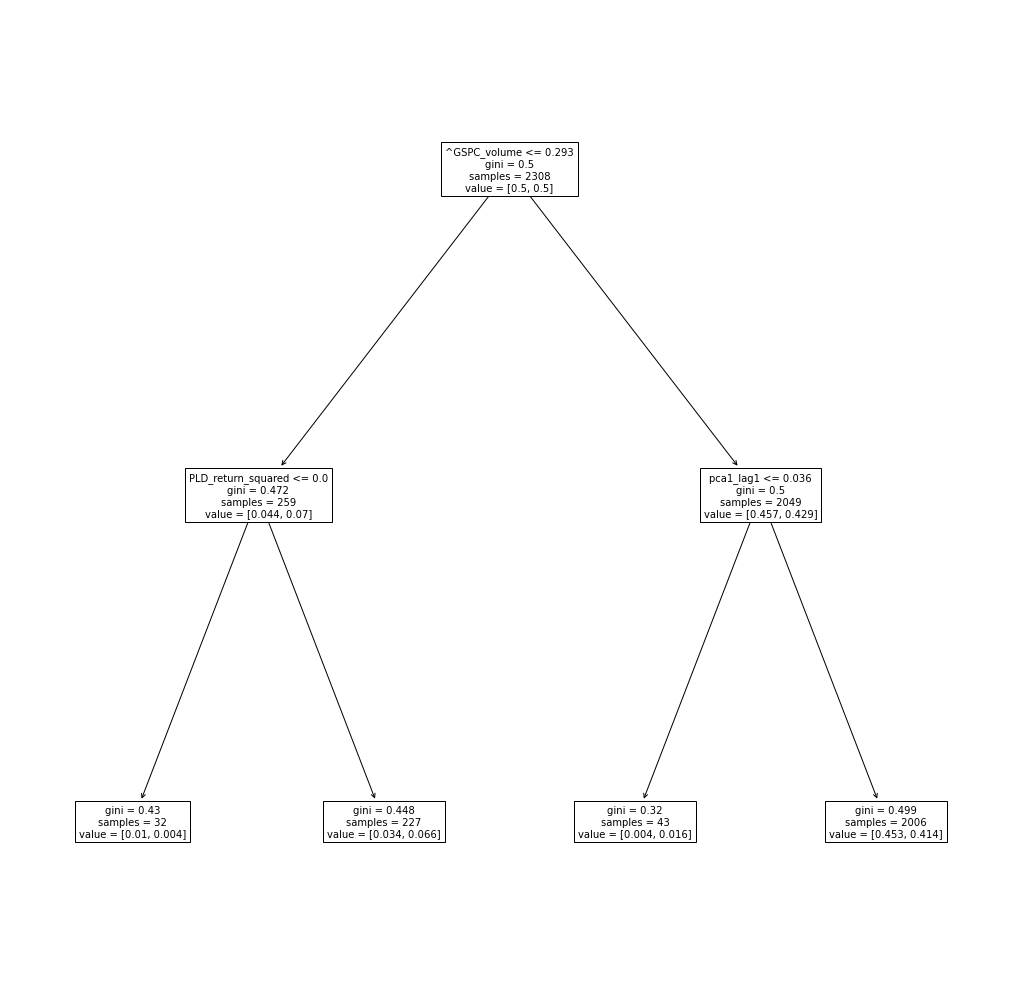

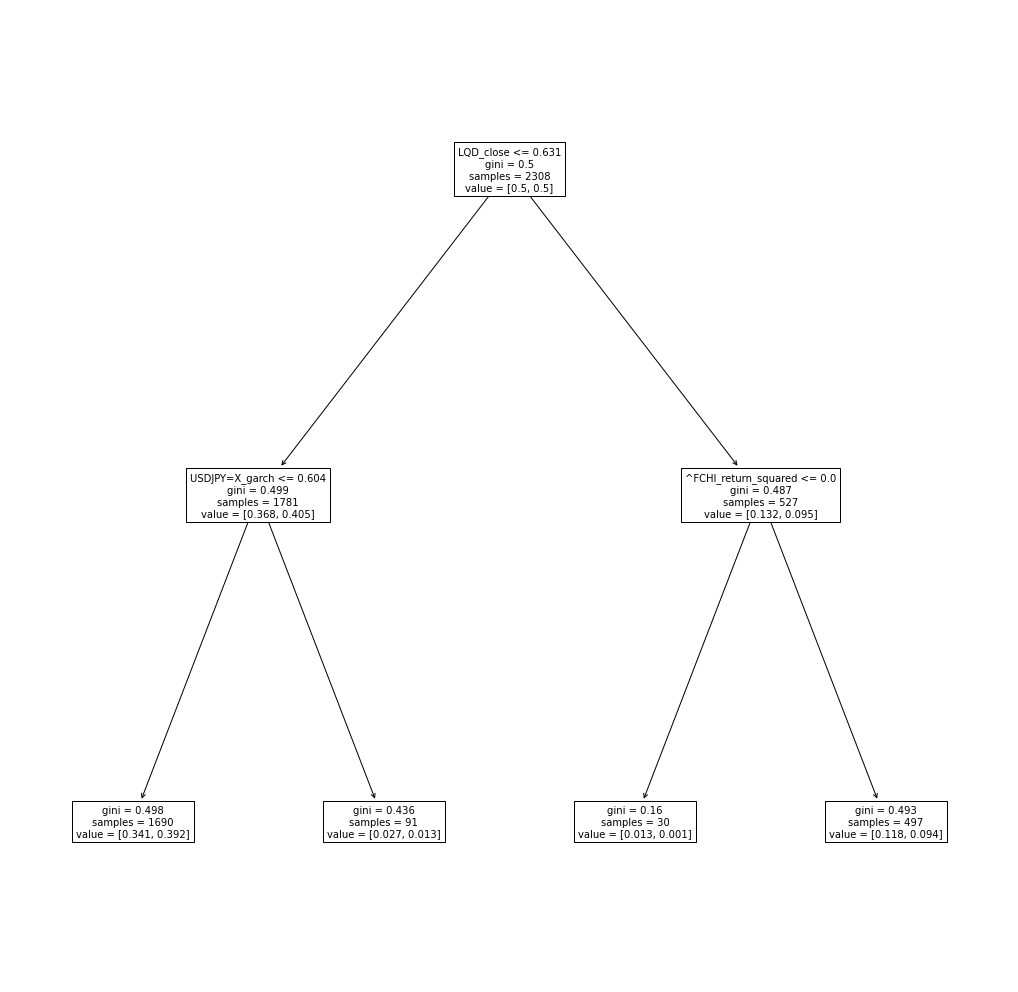

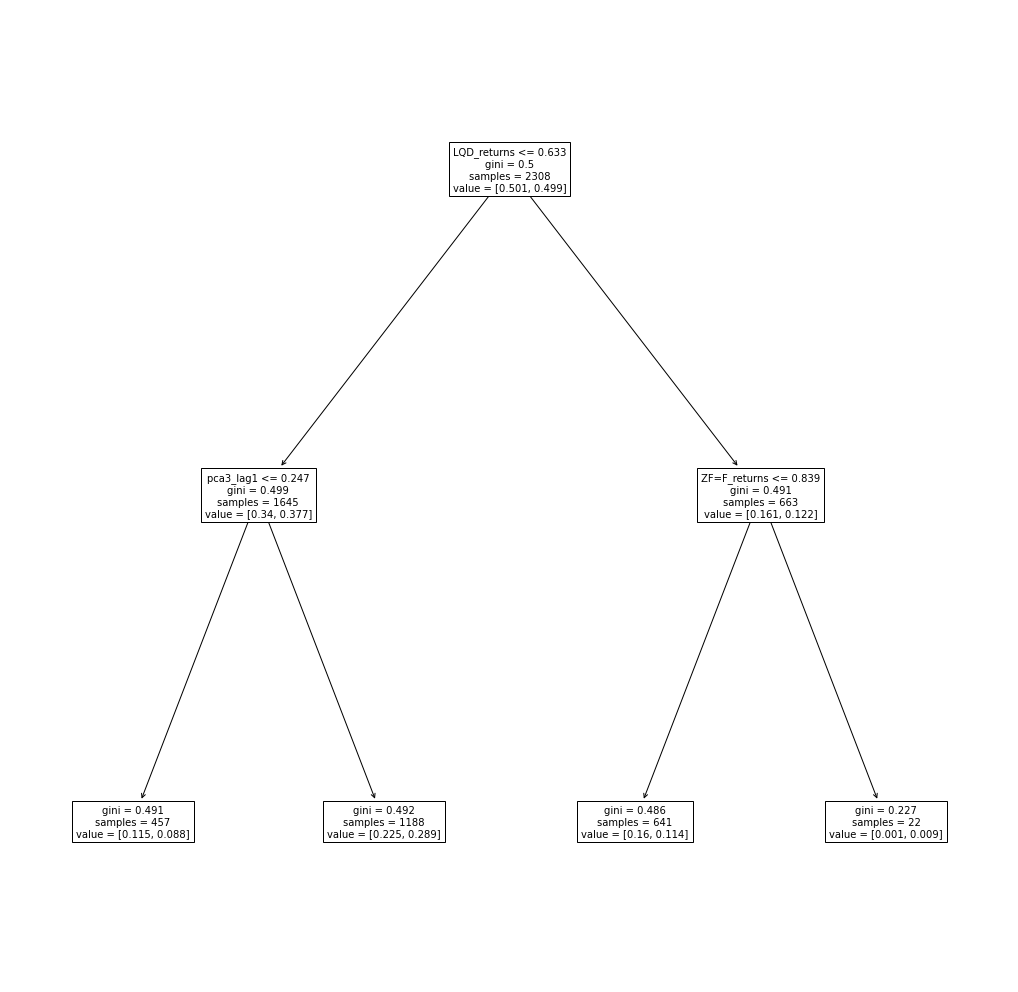

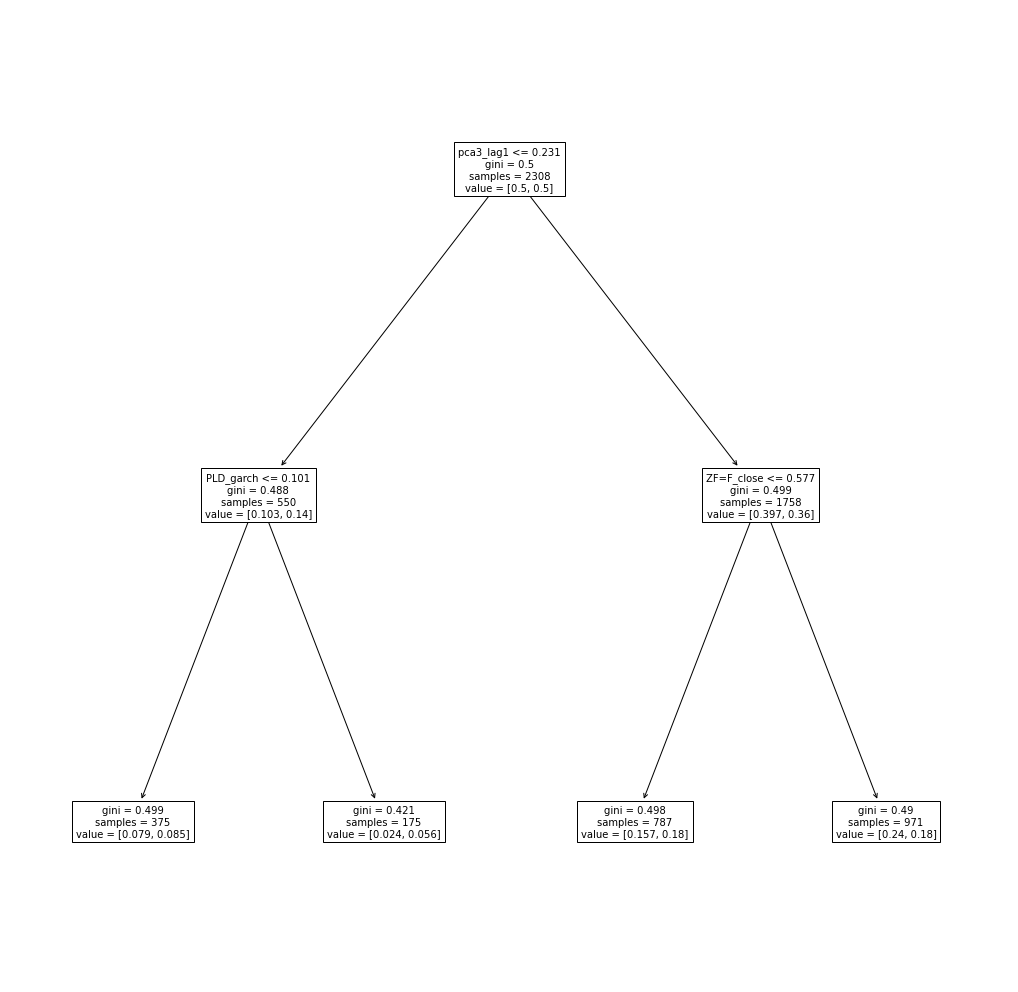

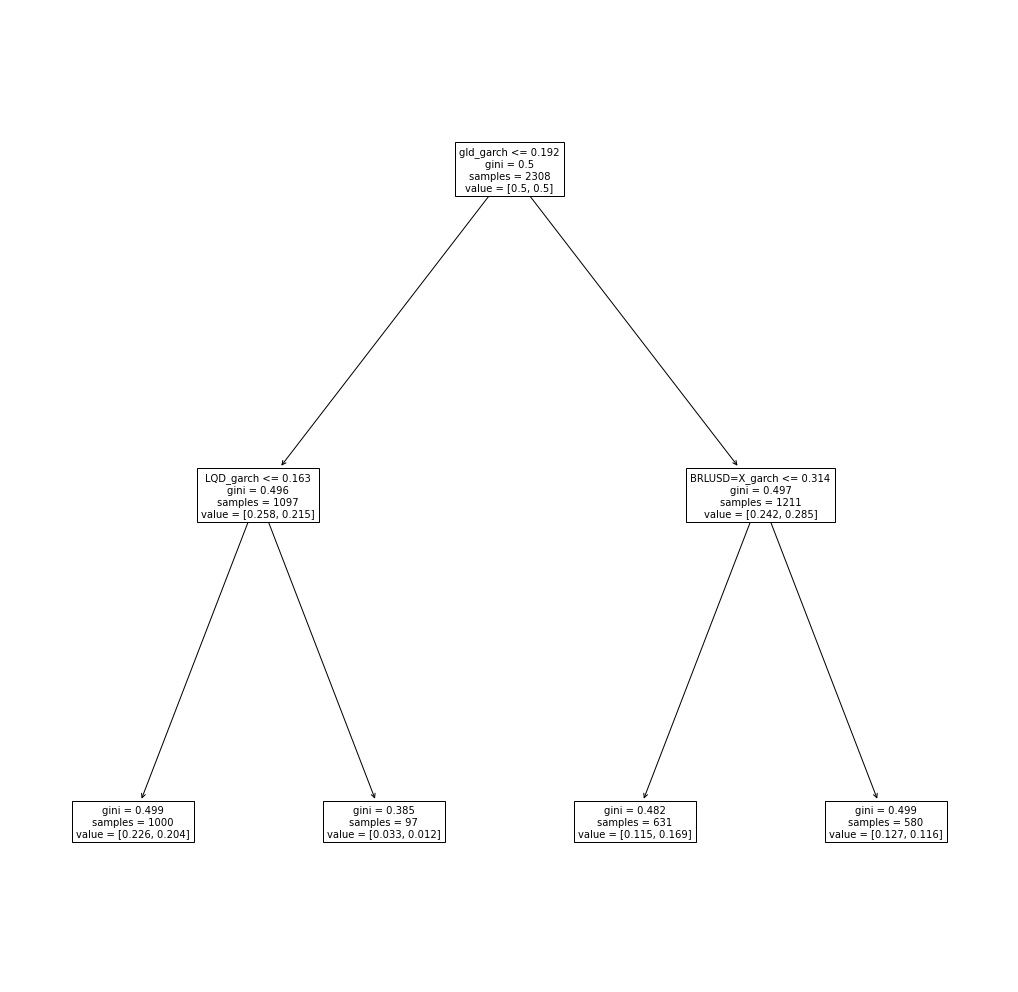

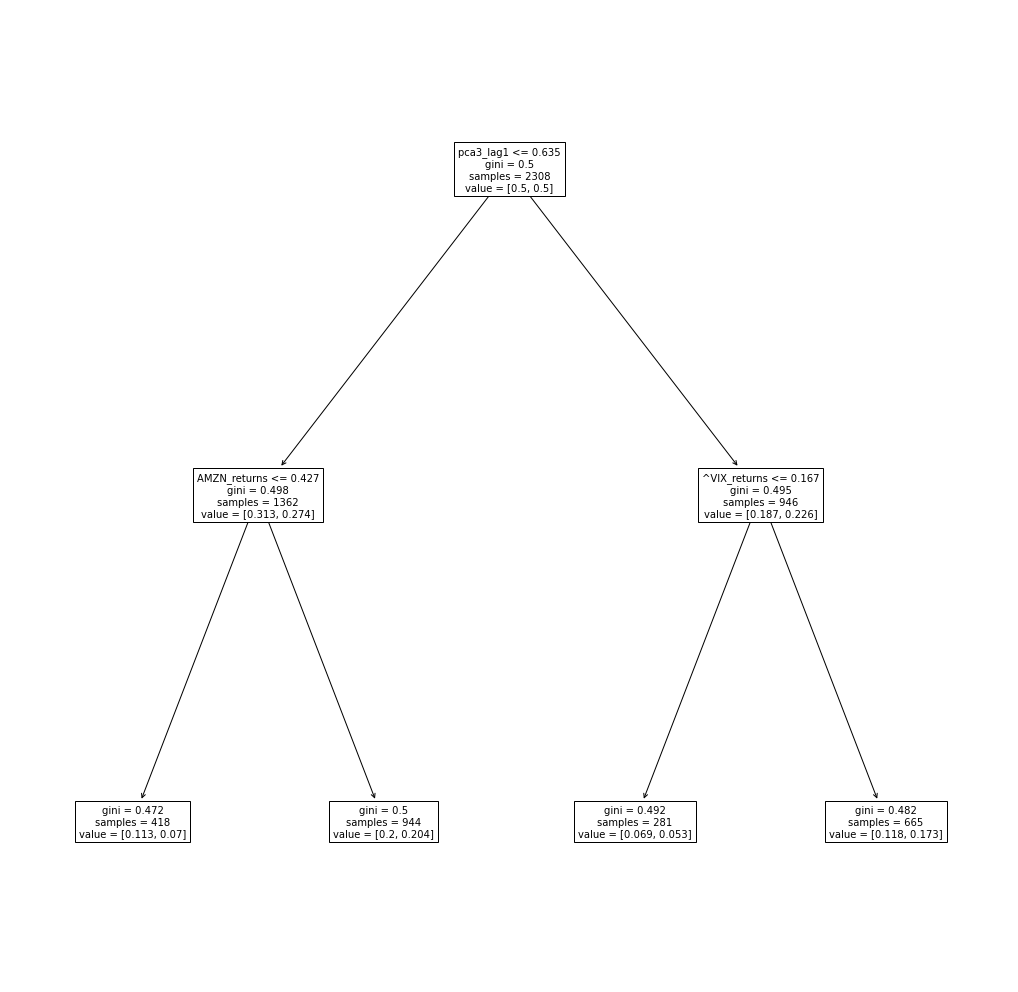

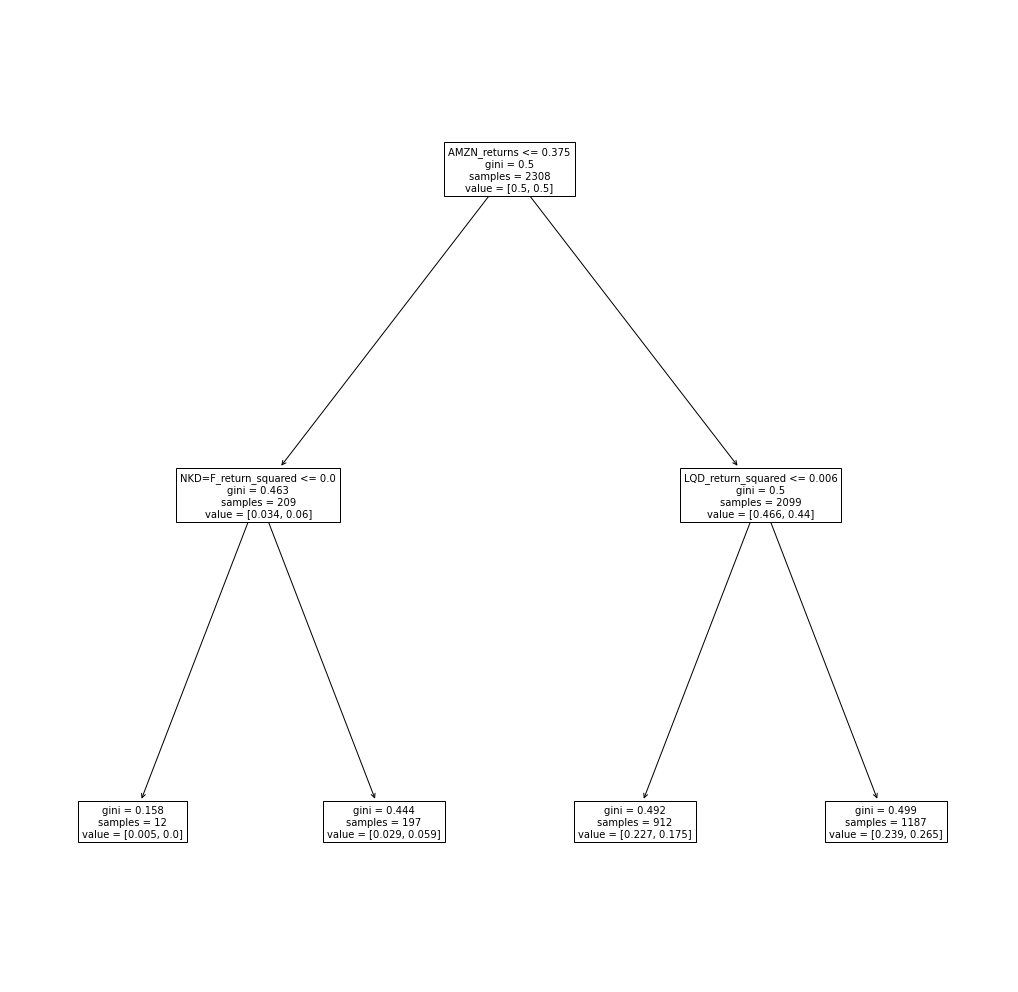

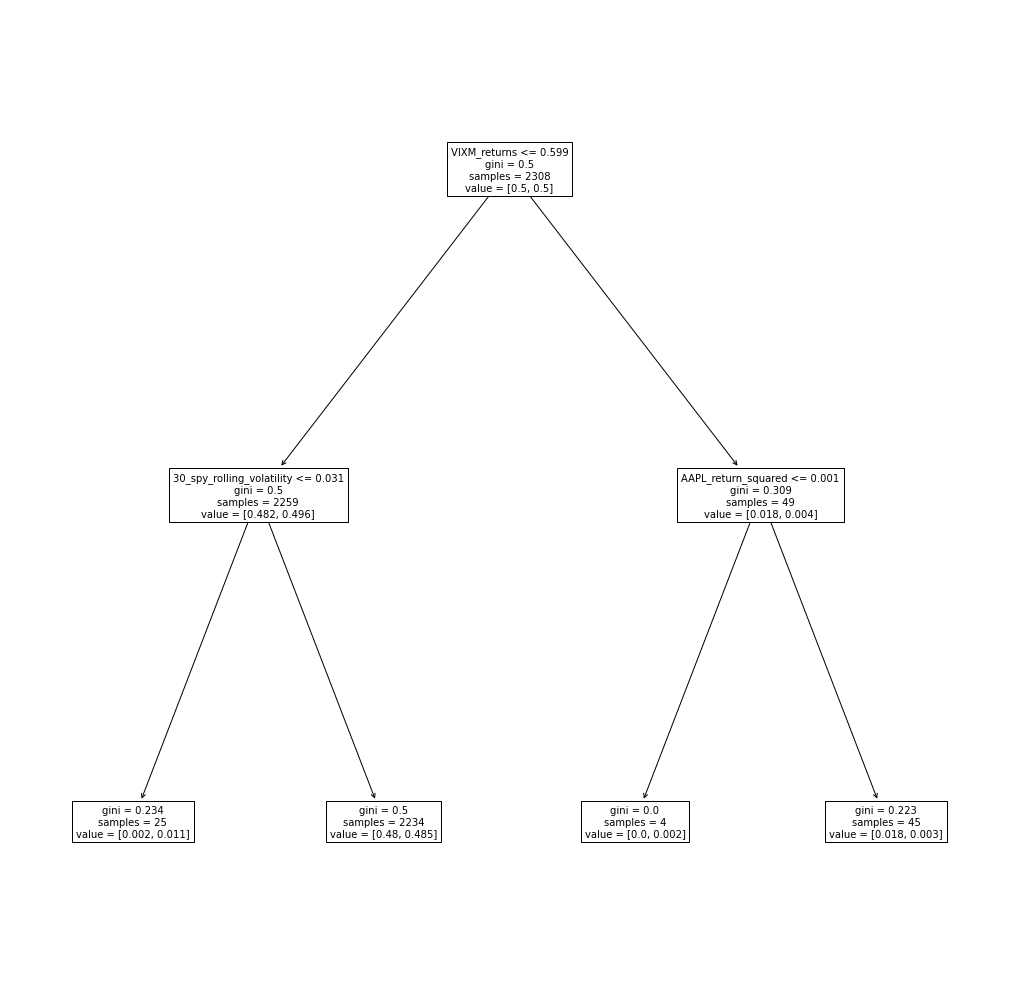

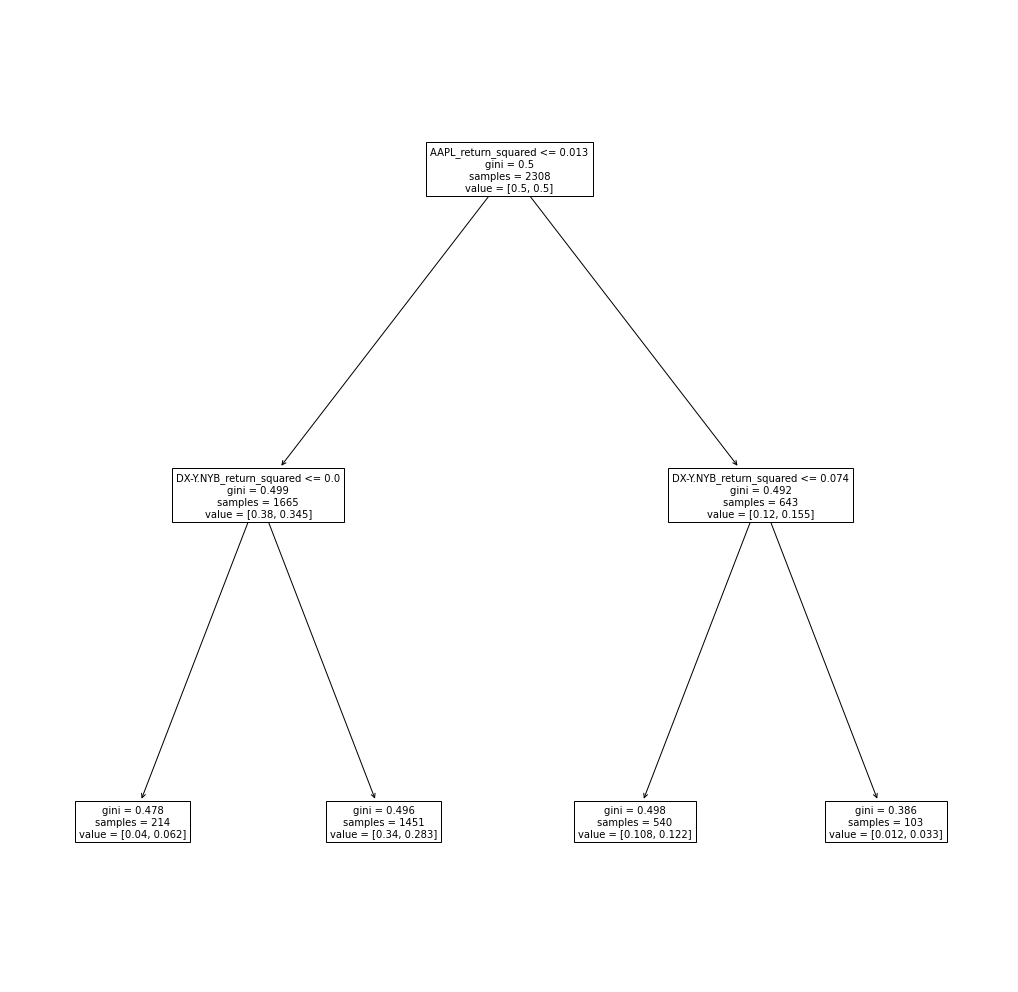

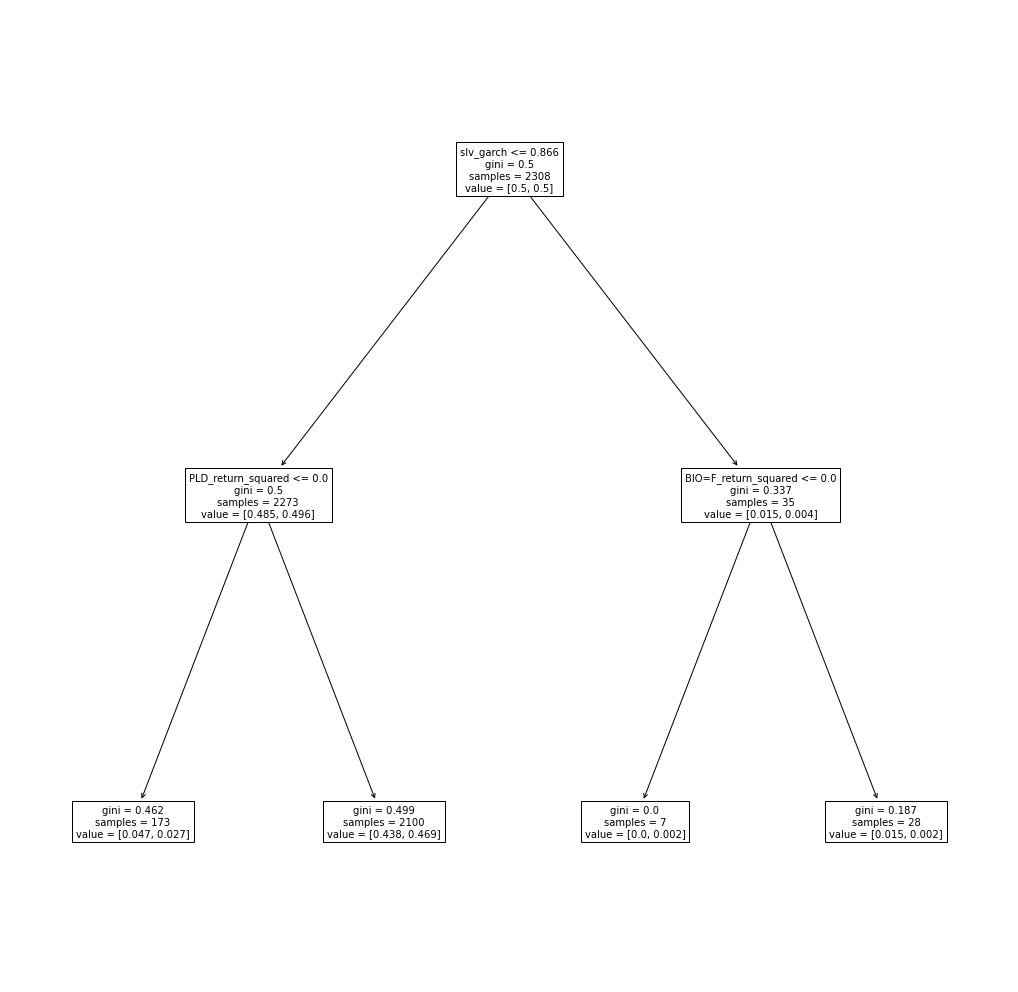

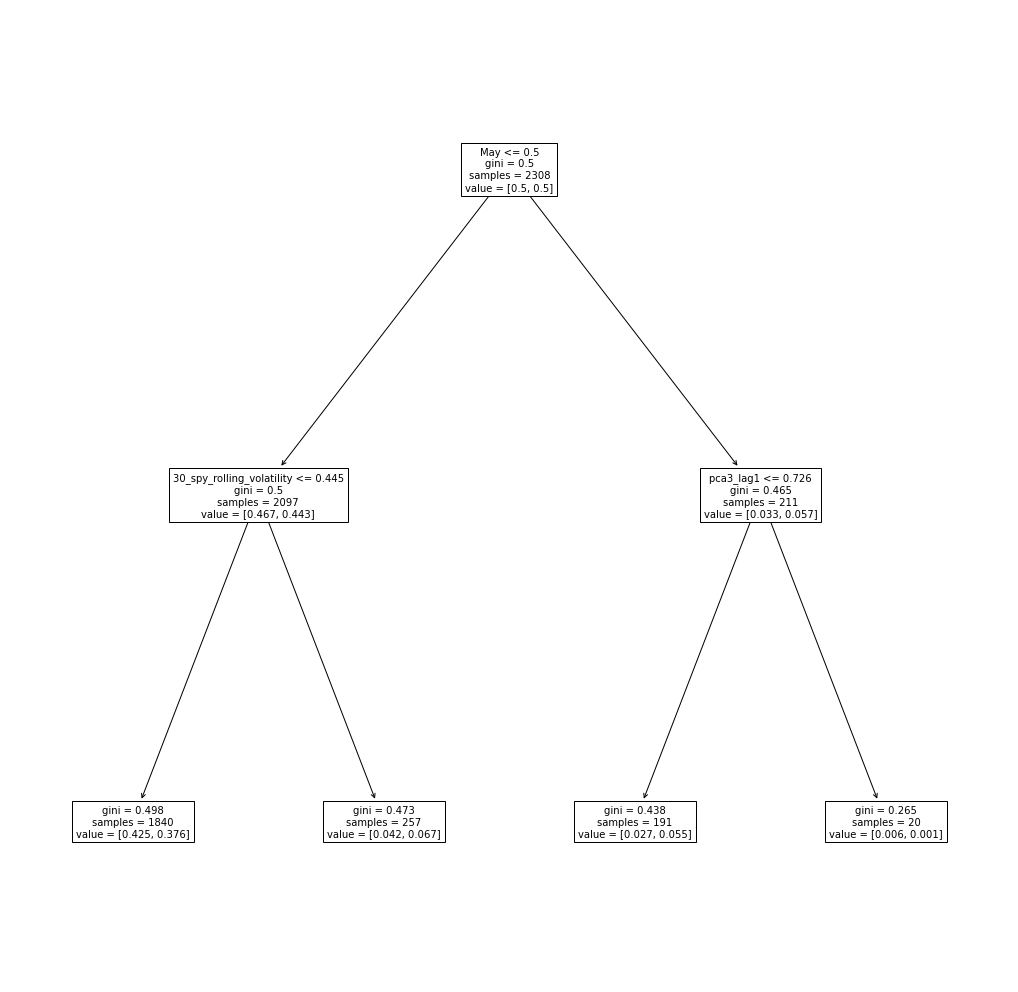

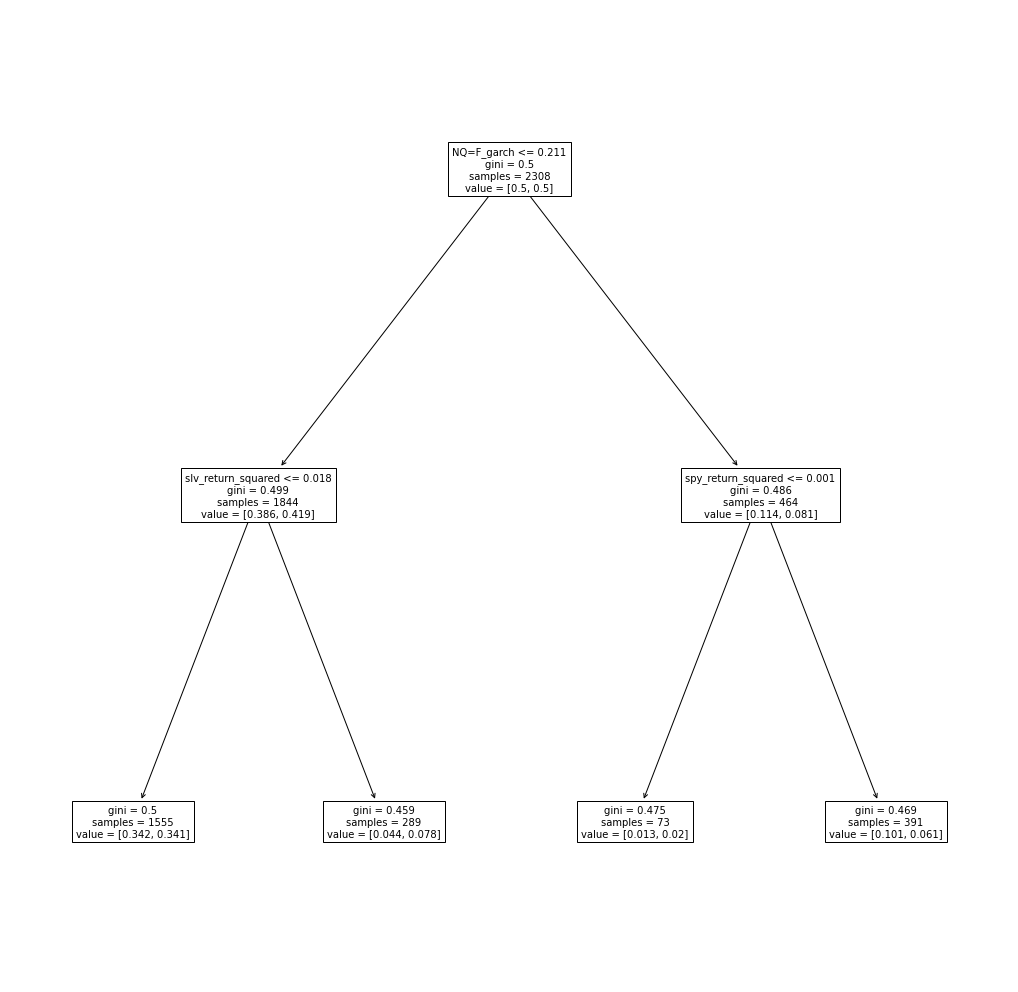

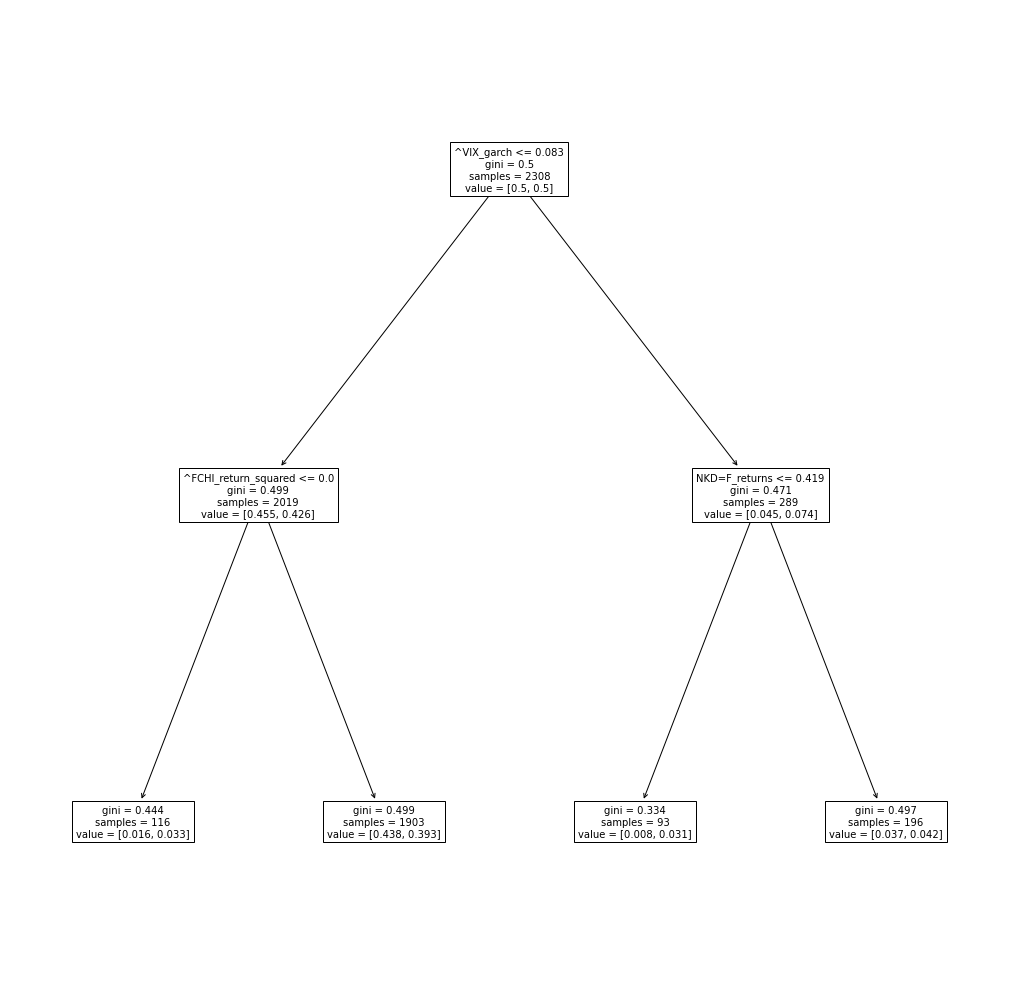

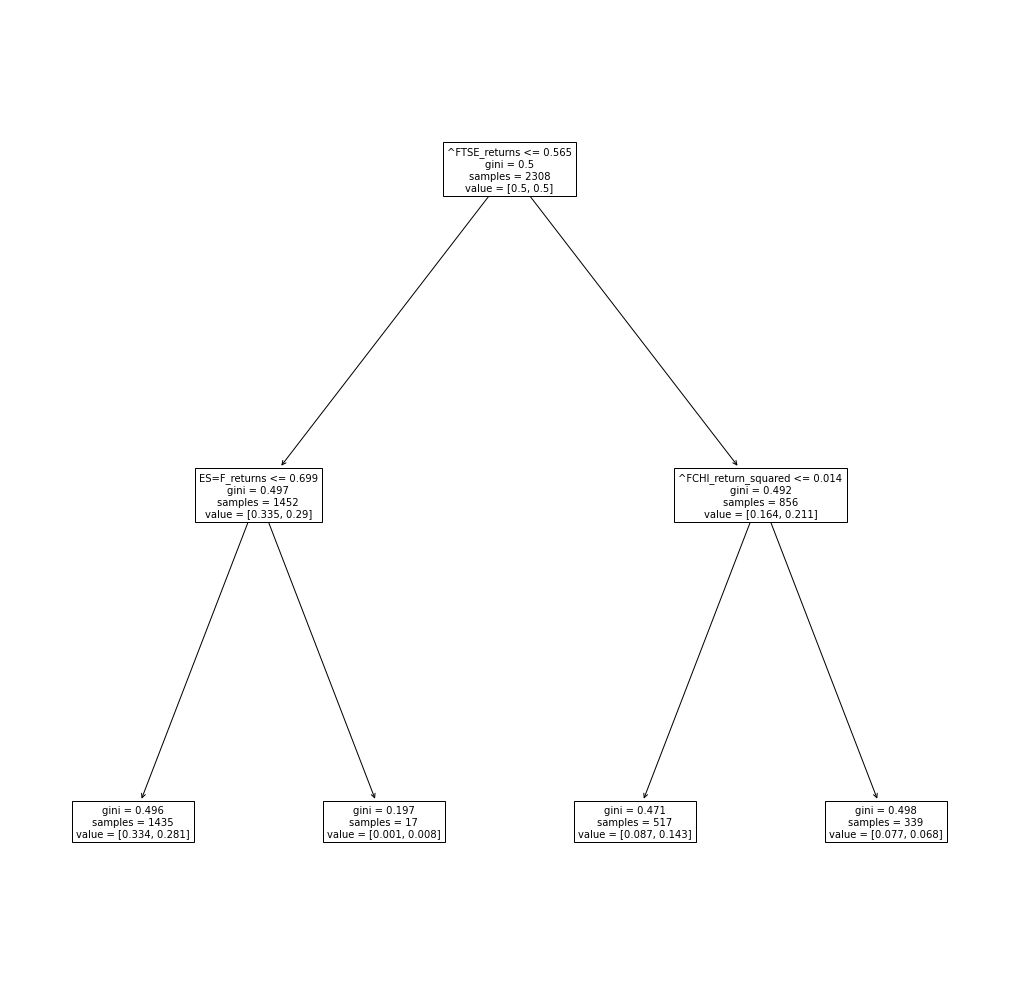

In [735]:
#from sklearn import tree
#adaboost_model.estimators_
#tree.plot_tree(adaboost_model.estimators_[0],fontsize=10)

#import matplotlib.pyplot as plt
# plot tree

for i in range(0,len(adaboost_model.estimators_)):
    plt.figure(figsize=(18,18))  # set plot size (denoted in inches)
    tree.plot_tree(adaboost_model.estimators_[i],fontsize=10, feature_names=X.columns, proportion=False)
    plt.show()

# Profitability Analysis
The large size of VIX returns would make a huge compounding effect if it were possible to bet on it and track its performance,.
As can be seen below, the average size of daily returns are around 5%, with returns that can get as large as 115% in one day. The median is 

In this section we will compare the results of betting on the model applying an imaginary strategy of betting at the open of the day, and close the bet at the end of the day. We will assume that the approximately the open level will be very similar than the close level of the previous day.

In [736]:
# VIX size of returns (in absolute value and %)
vixm_return_statistics=abs(100 * security_returns_df['VIXM']).describe()
display(vixm_return_statistics)

count    2821.000000
mean        1.386603
std         1.504313
min         0.000000
25%         0.431677
50%         0.987385
75%         1.850884
max        18.214719
Name: VIXM, dtype: float64

In [737]:
vixm_ret.loc['2011-02-21']
#y_train_df.index.min()
#y_train_df.index.max()

VIXM_ret    0.059293
Name: 2011-02-21 00:00:00, dtype: float64

### In-sample analysis: Return on $1 invested on training data window

In [738]:
# Results comnparison

# Profitability on the train window
fit_train= adaboost_model.predict(X_train_scaled)
fit_train_df= pd.DataFrame(fit_train, index=X_train.index)

fit_train_df.hvplot()

y_train_df=pd.DataFrame(y_train, index=X_train.index)
y_train_df

vixm_returns_train_df = vixm_ret.loc[y_train_df.index.min():y_train_df.index.max()]
vixm_returns_train_df = vixm_returns_train_df.loc[y_train_df.index]


# SPY as benchmark
spy_in_sample_period_returns=security_returns_component_df['spy'].loc[y_train_df.index.min():y_train_df.index.max()]


results_train_df=pd.concat([vixm_returns_train_df, y_train_df, fit_train_df, spy_in_sample_period_returns], axis=1)
print(results_train_df)

results_train_df.columns=['VIXM Return', 'Correct Signal', 'Fit Signal', "SPY returns"]

predicted_return=np.multiply(results_train_df['VIXM Return'],results_train_df['Fit Signal'])
max_return=np.multiply(results_train_df['VIXM Return'],results_train_df['Correct Signal'])


results_train_df=pd.concat([results_train_df, predicted_return, max_return], axis=1)
print(results_train_df)
results_train_df.columns=['VIXM Return', 'Correct Signal', 'Fit Signal', "SPY Return", 'VIXCOIN Token Return', "Max Return"]


return_of_one_dollar_in_train_window_df=(1+results_train_df[['VIXM Return', "SPY Return", 'VIXCOIN Token Return', "Max Return"]]).cumprod()
return_of_one_dollar_in_train_window_df.columns=['VIXM ETN', "SPY Return", 'VIXCOIN Token(in sample)', "Max Return"]

profitability_train_plot=return_of_one_dollar_in_train_window_df[['VIXCOIN Token(in sample)','VIXM ETN', "SPY Return" ]].hvplot(
                                             title="In-Sample Growth of $1 initial Investment in VIXCOIN Token",
                                             ylabel="Dollars $" ,
                                             width=1000,
                                             color=['green','red','blue']
 )

profitability_train_plot
#results_train_df[["Correct Signal", "Fit Signal"]].head(20)
#(1+predicted_return).cumprod().tail(400)
#return_of_one_dollar_in_train_window_df.tail()

            VIXM_ret  Signal    0       spy
Date                                       
2011-02-21  0.059293     1.0  1.0 -0.020070
2011-02-22       NaN     NaN  NaN  0.000000
2011-02-23  0.026566     1.0  0.0 -0.006144
2011-02-24  0.001107     1.0  1.0 -0.000687
2011-02-25 -0.035941     0.0  1.0  0.010693
...              ...     ...  ...       ...
2019-10-15 -0.010252     0.0  0.0  0.009900
2019-10-16  0.000432     1.0  1.0 -0.001606
2019-10-17 -0.009491     0.0  0.0  0.002949
2019-10-18  0.014373     1.0  0.0 -0.004377
2019-10-21 -0.016316     0.0  0.0  0.006779

[2261 rows x 4 columns]
            VIXM Return  Correct Signal  Fit Signal  SPY returns         0  \
Date                                                                         
2011-02-21     0.059293             1.0         1.0    -0.020070  0.059293   
2011-02-22          NaN             NaN         NaN     0.000000       NaN   
2011-02-23     0.026566             1.0         0.0    -0.006144  0.000000   
2011-02-24   

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [739]:
y_train_df.index

DatetimeIndex(['2011-02-21', '2011-02-23', '2011-02-24', '2011-02-25',
               '2011-02-28', '2011-03-01', '2011-03-02', '2011-03-03',
               '2011-03-04', '2011-03-07',
               ...
               '2019-10-08', '2019-10-09', '2019-10-10', '2019-10-11',
               '2019-10-14', '2019-10-15', '2019-10-16', '2019-10-17',
               '2019-10-18', '2019-10-21'],
              dtype='datetime64[ns]', name='Date', length=2163, freq=None)

### Out-of--sample analysis: Return on $1 invested on training data window

In [740]:
# Results comnparison

# Profitability on the test window

# Out-of-sample Predictions 
prediction_test= adaboost_model.predict(X_test_scaled)
prediction_test_df= pd.DataFrame(prediction_test, index=X_test.index)

# Out-of-sample signals (1s or 0s) based on actual returns of the VIX
y_test_df=pd.DataFrame(y_test, index=X_test.index)
y_test_df

# VIXM returns in the test window
vixm_returns_df=vixm_ret.loc[y_test_df.index.min():y_test_df.index.max()]
vixm_returns_test_df = vixm_returns_df.loc[y_test_df.index]

# Combination of VIXM Returns, signals and predictions
results_test_df = pd.concat([vixm_returns_test_df, y_test_df, prediction_test_df], axis=1)
results_test_df.columns = ['VIXM Return', 'Correct Signal', 'Predicted Signal']

# Predicted returns
predicted_return=results_test_df['VIXM Return']*results_test_df['Predicted Signal']
max_return=results_test_df['VIXM Return']*results_test_df['Correct Signal']

# SPY as benchmark
spy_out_of_sample_period_returns=security_returns_component_df['spy'].loc[y_test_df.index]

# DataFrame with out-of-sample results for comparison
results_test_df=pd.concat([results_test_df, predicted_return, max_return, spy_out_of_sample_period_returns], axis=1)
results_test_df.columns=['VIXM Return', 'Correct Signal', 'Predicted Signal', 'Predicted Return', "Max Return", "Benchmark: SPY"]

return_of_one_dollar_in_test_window_df=(1+results_test_df[['Predicted Return','VIXM Return',  "Benchmark: SPY"]]).cumprod()
return_of_one_dollar_in_test_window_df.columns=['VIXCOIN Token (out of sample)', 'VIXM ETN', 'Benchmark: SPY ETF']


#Plot with out of sample return on a 1 dollar investment for the VIX, and the daily bet strategy

# Set plot and style options
roi_token=-1+return_of_one_dollar_in_test_window_df['VIXCOIN Token (out of sample)'].iloc[-1]
roi_spy=-1+return_of_one_dollar_in_test_window_df['Benchmark: SPY ETF'].iloc[-1]

title=f" Growth of $1 investment in VIXCOIN Token since October 2019.             Token Return: {roi_token*100:.1f}%   SPY Return: {roi_spy*100:.1f}%"
profitability_test_plot=return_of_one_dollar_in_test_window_df.hvplot(
                         title=title,
                         ylabel= "Dollars $",
                         width=1200,
                         height=500,
                         color=["green","red","blue"]
                         #,legend="bottom"
                        
                )

profitability_test_plot

#predicted_return.hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [741]:
# Bar graph comparison of returns
start_date_plot=str(results_test_df.index[0].date())
title=f"Cummulative Return on Investment Comparison. Starting period: {start_date_plot}"
roi_plot_df=(100*return_of_one_dollar_in_test_window_df)
roi_plot_df.columns=["VIXCOIN Token", "VIXM ETN", "SPY ETF"]
roi_plot_df=roi_plot_df.iloc[-1]

roi_plot_df.hvplot(
    kind='bar',
    ylabel='Return (%)',
    title=title
    )


:Bars   [index]   (2021-11-23 00:00:00)

In [742]:
# Token Price


# Set plot and style options
roi_token=(1+predicted_return).cumprod()[-1]
title=f"VIXCOIN Token Pricing example, initiated in October 2019.                Current price: {roi_token:.2f}"

token_price_curve_plot=return_of_one_dollar_in_test_window_df.hvplot(
                         y=['VIXCOIN Token (out of sample)', 'Benchmark: SPY ETF'],
                         title=title,
                         ylabel= "Dollars $",
                         width=1100,
                         color=["green","blue"])

first_point=return_of_one_dollar_in_test_window_df.head(1)
last_point =return_of_one_dollar_in_test_window_df.tail(1)
max_token  =return_of_one_dollar_in_test_window_df[return_of_one_dollar_in_test_window_df['VIXCOIN Token (out of sample)']==return_of_one_dollar_in_test_window_df['VIXCOIN Token (out of sample)'].max()].head(1)
min_spy    =return_of_one_dollar_in_test_window_df[return_of_one_dollar_in_test_window_df['Benchmark: SPY ETF']==return_of_one_dollar_in_test_window_df['Benchmark: SPY ETF'].min()].head(1)

key_points=pd.concat([first_point, min_spy, max_token, last_point], axis=0)
key_points_token=key_points['VIXCOIN Token (out of sample)']
key_points_spy=key_points['Benchmark: SPY ETF']



token_key_point=return_of_one_dollar_in_test_window_df[['VIXCOIN Token (out of sample)', 'Benchmark: SPY ETF']].loc[key_points.index].hvplot(
                kind='scatter',
                marker="^",
                size=200,
                legend=False,
                ylabel='Price in $',
                width=1000,
                height=400,
                color=['green','blue']
)

token_key_point*token_price_curve_plot



:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Scatter   [Date]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [Date]   (value)

In [743]:
key_points.index

DatetimeIndex(['2019-10-22', '2020-03-23', '2021-03-08', '2021-11-23'], dtype='datetime64[ns]', name='Date', freq=None)

In [744]:
prediction_test_df.hvplot(width=1200, kind='bar', color=['black'])*(5*vixm_returns_df).hvplot(kind='bar', color=["yellow"],
                                                                            title="How the algorithm avoids time decay?",
                                                                            ylabel="Signal and VIXMx5 return")

:Overlay
   .Bars.I  :Bars   [Date]   (0)
   .Bars.II :Bars   [Date]   (VIXM_ret)

In [745]:
# output for jason
# csv file with [token value, VIXM, SPY] for all history 
y_hat_df=pd.concat([fit_train_df, prediction_test_df], axis=0)
y_hat_df.columns=['Signal_hat']
jason_df=pd.concat([y_hat_df, X2['VIXM_returns'], X2['spy_returns'],X1['VIXM_close'], X1['spy_close']], axis=1)

growth_1dollar_investment_df=(1+jason_df[['VIXM_returns', 'spy_returns']]).cumprod()
print(growth_1dollar_investment_df)
growth_1dollar_investment_df.rename({'VIXM_returns':'VIXM_growth_1dollar', 'spy_returns':'spy_growth_of_1dollar'}, axis=1, inplace=True)



jason_df=pd.concat([jason_df,growth_1dollar_investment_df],axis=1)

jason_df["Signal_hat"]=jason_df["Signal_hat"].fillna(0)

token_returns=np.multiply(jason_df['Signal_hat'], jason_df['VIXM_returns'])
token_returns.rename({"0":"Token_Returns"}, axis=1, inplace=True)
token_price_df=(1+token_returns).cumprod()
token_price_df.rename({"0":"Token_Price"}, axis=1, inplace=True)
jason_df=pd.concat([jason_df,token_returns, token_price_df],axis=1)
jason_df.columns=['Signal_hat','VIXM_returns','spy_returns','VIXM_close','spy_close','VIXM_growth_1dollar','spy_growth_of_1dollar','Token_returns','VIXCOIN_token_growth_1dollar']

#print(y_hat_df)
#print(jason_df.loc['2011-02-21':])
jason_df=jason_df.dropna()
jason_df.to_csv("demo_data/Jason_output_file.csv", index=True)

jason_df[['spy_growth_of_1dollar','VIXCOIN_token_growth_1dollar', 'VIXM_growth_1dollar' ]].hvplot(
    legend ='bottom',
    title  ='VIXCOIN Token growth of $1 investment at the beggining of VIXM in Feb 11th 2011',
    height=500,
    ylabel="$"
)

#print(jason_df[['spy_growth_of_1dollar','Growth_1dollar_invested_in_token_same_as_Token_Price_if_started_on_2011', 'VIXM_growth_1dollar' ]])




            VIXM_returns  spy_returns
Date                                 
2011-02-01           NaN          NaN
2011-02-02      0.997817     0.998088
2011-02-03      0.991850     1.000306
2011-02-04      0.979624     1.003136
2011-02-07      0.967254     1.009408
...                  ...          ...
2021-11-18      0.112284     4.427016
2021-11-19      0.112102     4.419100
2021-11-22      0.113048     4.406659
2021-11-23      0.111665     4.412502
2021-11-24      0.111665     4.412502

[2822 rows x 2 columns]


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

### Comments
0. The VIXM invest in VIX Futures in order to make profit.
1. The VIXM has massive positive returns in moments of crushes in the market, and tends to decay in time due to the rolling effect on its futures contracts. 
2. Due to the decay effect, VIXM can only be profitable for short term trades. Should not be used in a buy and hold strategy.
3. Our algorithmic trading investment strategy on VIXM takes advantage of the good return in market crushes, and in addition allows to generate profit during bull markets.
4. The VIXCoin investment works like a buy and hold strategy, and offers an investment opportunity to diversify a portfolio to reduce risk.


In [746]:
# Graph with SPY as benchmark
#benchmark_spy_out_of_sample_period_df=(1+security_returns_component_df['spy'].loc[y_test_df.index.min():y_test_df.index.max()]).cumprod()
#benchmark_spy_out_of_sample_period_df.hvplot()

In [747]:
# Results in prediction of daily returns
min_return=threshold
results_test_for_plot_df=results_test_df[abs(results_test_df['VIXM Return'])>min_return]*100

results_test_for_plot_df.hvplot(
                    y=['VIXM Return', 'Predicted Return'],
                    title= "Out-of-sample predictions of VIXM return",
                    width=1000,
                    ylabel='Daily Return (%)'
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [748]:
#Histogram of returns out of sample
results_test_for_plot_df.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title= "Out-of-sample VIXM returns predictions"
)

:NdOverlay   [Element]
   :Histogram   [Predicted Return]   (Predicted Return_count)

### Analysis of good and bad predictions

In [749]:
# Analysis of the good and bad out-of-sample predictions
good_predictions=results_test_df[results_test_df['Correct Signal']==results_test_df['Predicted Signal']]

bad_predictions=results_test_df[results_test_df['Correct Signal']!=results_test_df['Predicted Signal']]


In [750]:
good=good_predictions.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title= "Out-of-sample VIX Returns of Good Predictions"
)

bad=bad_predictions.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title= "Out-of-sample VIX Returns on Bad Predictions"
)
good+bad

:Layout
   .NdOverlay.I  :NdOverlay   [Element]
      :Histogram   [Predicted Return]   (Predicted Return_count)
   .NdOverlay.II :NdOverlay   [Element]
      :Histogram   [Predicted Return]   (Predicted Return_count)

### Observations
We see that the number of negative returns that are dismissed are similar to the ones avoided when returns are small. However, for large tailed negative returns, there are significantly many more that are avoided (9+6 =15) than the ones that are not avoided (3+1 = 4 )

In [751]:
# Good prediction statistics
good_predictions[['VIXM Return', 'Predicted Return']].describe()

,VIXM Return,Predicted Return
count,273.000000,273.000000
mean,0.007677,0.012633
std,0.029753,0.025767
min,-0.054111,-0.022076
25%,-0.007437,0.000000
50%,0.004214,0.004214
75%,0.013650,0.013650
max,0.182147,0.182147


In [752]:
# Bad prediction statistics
bad_predictions[['VIXM Return', 'Predicted Return']].describe()

,VIXM Return,Predicted Return
count,251.000000,251.000000
mean,-0.006511,-0.010485
std,0.021151,0.015590
min,-0.140413,-0.140413
25%,-0.015097,-0.015097
50%,-0.006425,-0.006219
75%,0.002307,0.000000
max,0.087527,0.000278


In [753]:
# Box Plot predictions for good and bad predictions
good_pred=good_predictions['Predicted Return']
bad_pred =bad_predictions['Predicted Return']

predictions_comparison_df=pd.concat([good_predictions['Predicted Return'],bad_predictions['Predicted Return']], axis=1, ignore_index=True )*100
predictions_comparison_df.hvplot(kind='box',
                                height=800,
                                ylabel='Return (%)',
                                #clabel=['Good Predictions', 'Bad Predictions'],
                                cmap=['blue','red'],
                                title="Out-of-sample Good and Bad Returns Resulting from Model Predictions Box Plots")





#df = pd.DataFrame(np.random.randn(20), columns=['Value'])
#df['Source'] = ['Preds'] *10 +['Real'] * 10
#df['Item'] = ['item1'] *5 + ['item2']*5 + ['item1'] *5 + ['item2']*5
#df.hvplot.box(y='Value', by=['Item', 'Source'])

#n_estimators 22, Trying deph 1, learning rate 1.8 -- get to perfect accuracy.

:BoxWhisker   [Variable]   (value)

# Tunning
### OUTPUTS FOR TUNNING

In [754]:
def prepare_features(XY, pca_components):
    XY_modified = XY.shift().dropna()
    y = XY_modified["Signal"].shift(-1)
    X = XY_modified
    pca = PCA(n_components = pca_components)
    principal_components = pca.fit_transform(X)
    
    pca_column_list = []
    for i in range(1, pca_components+1):
        pca_column_list.append(f"pca{i}")

    principal_components_train_test_df = pd.DataFrame(data = principal_components, columns = pca_column_list, index = XY_modified.index)
    X_pca_lag1 = create_pca_lag1(principal_components_train_test_df)
    X_pca_lag2 = create_pca_lag2(principal_components_train_test_df)
    X_pca_lag3 = create_pca_lag3(principal_components_train_test_df)
    X_pca_lag4 = create_pca_lag4(principal_components_train_test_df)
    X_pca_lag5 = create_pca_lag5(principal_components_train_test_df)
        
    X_pc_lags = concatenate_lags(X_pca_lag1, X_pca_lag2, X_pca_lag3, X_pca_lag4, X_pca_lag5)
    X_pc = concatenate_pca_with_lags(principal_components_train_test_df, X_pc_lags)
    X, y = eliminate_nans_in_pca_data(X_pc, y)
    
    X_train, y_train, X_test, y_test = split_training_test_data(X, y)
    X_train_resampled, y_train_resampled = random_over_sample(X_train, y_train)
    X_train_scaled, X_test_scaled = standard_scale(X_train_resampled, X_test)
    #principal_components_train_test
    if parameter_tuning_mode == True:
        display(sum(pca.explained_variance_ratio_))
        display(principal_components_train_test_df.shape)
    return X_train_scaled, X_test_scaled, y_train_resampled, y_test

In [755]:
# GENERATING TUNING ON TRAIN ONLY

if run_multiple_tuning_iterations == True: 
    for num_estimators in range (1,25, 1):
        for depth in range(1,3,1):
            for rate in range(9,19,1):
                base = DecisionTreeClassifier(max_depth=depth)
                adaboost_model=AdaBoostClassifier(base_estimator=base, 
                                      n_estimators=num_estimators, 
                                      learning_rate= rate/10 )

                # Fit the model 
                adaboost_model = adaboost_model.fit(X_train_resampled, y_train_resampled)
                
                pred_adaboost= adaboost_model.predict(X_train_scaled)
                prediction_train_df= pd.DataFrame(pred_adaboost, index=X_train.index)
                
                #Calculate Peofitability
                # VIXM returns in the test window
                vixm_returns_df=vixm_ret.loc[y_train_df.index.min():y_train_df.index.max()]
                vixm_returns_train_df = vixm_returns_df.loc[y_train_df.index]

                # Combination of VIXM Returns, signals and predictions
                results_train_df=pd.concat([vixm_returns_train_df, y_train_df, prediction_train_df], axis=1)
                results_train_df.columns=['VIXM Return', 'Correct Signal', 'Predicted Signal']

                # Predicted returns (we don't use the correct signal, but the predicted signal)
                predicted_return_df=results_train_df['VIXM Return']*results_train_df['Predicted Signal']
                predicted_return_df.columns=['Date','VIXM_Strategy_return']
                roi_strategy_factor = (1+predicted_return_df).cumprod()[-1]
                             
        
                # Use a classification report to evaluate the model using the predictions and testing data
                adaboost_report=classification_report(y_train, pred_adaboost)

                #if num_estimators % 10 == 0 and num_components == 88:
                #    print(f"components {num_components} esimators {num_estimators}")
                #    print(f"f1 score 0 {f1_score(y_test, pred_adaboost, pos_label=0)} f1 score 1 {f1_score(y_test, pred_adaboost, pos_label=1)}")
                #    print(f"accuracy {accuracy_score(y_test, pred_adaboost)}")
                #    print(adaboost_report)
                f1_score_1 = f1_score(y_train, pred_adaboost, pos_label=1)
                f1_score_0 = f1_score(y_train, pred_adaboost, pos_label=0)
                recall_score_1 = recall_score(y_train, pred_adaboost, pos_label=1)
                recall_score_0 = recall_score(y_train, pred_adaboost, pos_label=0)
                accuracy_score_model = accuracy_score(y_train, pred_adaboost)
                if  accuracy_score_model >= .55 and f1_score_1 >= .55 and f1_score_0 >= .55 and recall_score_1 >= .55 and recall_score_0 >= .55 and roi_strategy_factor>10 :
                    print(f"estimators {num_estimators}, max tree deph: {depth},learning_rate:{rate/10}, growth of one dollar investment:{roi_strategy_factor}")
                    # print(f"variance explained {sum(pca.explained_variance_ratio_)}")
                    # Print the classification report
                    print("         AdaBoost Classification Report")
                    print(adaboost_report)
                print(f"n_estimators {num_estimators}, Trying deph {depth}, learning rate {rate/10}")

In [756]:
# GENERATING TUNING ON TEST RESULTS

if run_multiple_tuning_iterations == True: 
    for num_estimators in range (1,25, 1):
        for depth in range(1,3,1):
            for rate in range(1,20,1):
                base = DecisionTreeClassifier(max_depth=depth)
                adaboost_model=AdaBoostClassifier(base_estimator=base, 
                                      n_estimators=num_estimators, 
                                      learning_rate= rate/10 )

                # Fit the model 
                adaboost_model = adaboost_model.fit(X_train_resampled, y_train_resampled)
                pred_adaboost= adaboost_model.predict(X_test_scaled)
                prediction_test_df= pd.DataFrame(pred_adaboost, index=X_test.index)
                
                #Calculate Peofitability
                # VIXM returns in the test window
                vixm_returns_df=vixm_ret.loc[y_test_df.index.min():y_test_df.index.max()]
                vixm_returns_test_df = vixm_returns_df.loc[y_test_df.index]

                # Combination of VIXM Returns, signals and predictions
                results_test_df=pd.concat([vixm_returns_test_df, y_test_df, prediction_test_df], axis=1)
                results_test_df.columns=['VIXM Return', 'Correct Signal', 'Predicted Signal']

                # Predicted returns (we don't use the correct signal, but the predicted signal)
                predicted_return_df=results_test_df['VIXM Return']*results_test_df['Predicted Signal']
                predicted_return_df.columns=['Date','VIXM_Strategy_return']
                roi_strategy_factor = (1+predicted_return_df).cumprod()[-1]
                             
        
                # Use a classification report to evaluate the model using the predictions and testing data
                adaboost_report=classification_report(y_test, pred_adaboost)

                #if num_estimators % 10 == 0 and num_components == 88:
                #    print(f"components {num_components} esimators {num_estimators}")
                #    print(f"f1 score 0 {f1_score(y_test, pred_adaboost, pos_label=0)} f1 score 1 {f1_score(y_test, pred_adaboost, pos_label=1)}")
                #    print(f"accuracy {accuracy_score(y_test, pred_adaboost)}")
                #    print(adaboost_report)
                f1_score_1 = f1_score(y_test, pred_adaboost, pos_label=1)
                f1_score_0 = f1_score(y_test, pred_adaboost, pos_label=0)
                recall_score_1 = recall_score(y_test, pred_adaboost, pos_label=1)
                recall_score_0 = recall_score(y_test, pred_adaboost, pos_label=0)
                accuracy_score_model = accuracy_score(y_test, pred_adaboost)
                if  accuracy_score_model >= .50 and f1_score_1 >= .50 and f1_score_0 >= .50 and recall_score_1 >= .50 and recall_score_0 >= .50 and roi_strategy_factor>1 :
                    print(f"estimators {num_estimators}, max tree deph: {depth},learning_rate:{rate/10}, growth of one dollar investment:{roi_strategy_factor}")
                    # print(f"variance explained {sum(pca.explained_variance_ratio_)}")
                    # Print the classification report
                    print("         AdaBoost Classification Report")
                    print(adaboost_report)
                print(f"Trying n_estimators {num_estimators}, deph {depth},  learning rate {rate/10}")

# Future changes
Filter for correlation can be done with return or close